In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
sns.set_style('white')


In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')

In [4]:
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [5]:
meta_df = pd.read_excel('exp 6 transfer Apr2019.xlsx', sheet_name='sent for seq')
meta_df.rename(columns={'#': 'sample_number'}, inplace=True)
meta_df.sample_number = pd.to_numeric(meta_df.sample_number)

In [6]:
pd.__version__

'1.2.3'

In [7]:
import json
with open(os.path.join('DNA','dnaseq', 'qualimap_multiqc_data','multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [8]:

qualimap_json.keys()

dict_keys(['report_data_sources', 'report_general_stats_data', 'report_general_stats_headers', 'report_multiqc_command', 'report_plot_data', 'report_saved_raw_data', 'config_analysis_dir_abs', 'config_analysis_dir', 'config_creation_date', 'config_git_hash', 'config_intro_text', 'config_report_comment', 'config_report_header_info', 'config_script_path', 'config_short_version', 'config_subtitle', 'config_title', 'config_version'])

In [9]:
qmap_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [10]:
len(qualimap_json['report_general_stats_data'])

1

In [11]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
bamqc_df = pd.DataFrame([_item_to_dict(k,v) for k,v in qualimap_json['report_general_stats_data'][0].items()])

In [12]:
bamqc_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     550761.0      134228.0           24.371370                0.44   
1      79690.0        9854.0           12.365416                3.72   
2     268388.0       54226.0           20.204331                0.18   
3     221198.0        1103.0            0.498648               11.42   
4     261903.0      251977.0           96.210047                0.28   

   mean_coverage             Key  median_coverage  median_insert_size  avg_gc  \
0         4.8599         12_1A3               NaN                 NaN     NaN   
1         0.3646          21_DE               NaN                 NaN     NaN   
2         4.9590     18_MIT0604               NaN                 NaN     NaN   
3         0.0442  17_Maricaulis               NaN                 NaN     NaN   
4         9.0282         06_1A3               NaN                 NaN     NaN   

   1_x_pc  5_x_pc  10_x_pc  30_x_pc  50_x_pc  
0     NaN     NaN      NaN      NaN      NaN  
1     NaN     NaN      NaN      NaN      NaN  
2     NaN     NaN      NaN      NaN      NaN  
3     NaN     NaN      NaN      NaN      NaN  
4     NaN     NaN      NaN      NaN      NaN

In [13]:
bamqc_df = bamqc_df.pivot_table(index='Key').reset_index()
bamqc_df = bamqc_df.loc[~bamqc_df.Key.isin(['08_1A3', '08_MIT9313'])]
bamqc_df[['sample_number', 'species']] = bamqc_df.Key.str.split('_', expand=True)
bamqc_df['sample_number'] = pd.to_numeric(bamqc_df['sample_number'])
bamqc_df = bamqc_df.loc[bamqc_df.sample_number != 8]

bamqc_df.head()


Key    10_x_pc     1_x_pc    30_x_pc    50_x_pc     5_x_pc  \
0         01_1A3   99.665126  99.986713  44.556351   2.066889  99.956183   
1          02_DE   99.530857  99.948538  42.842870   1.027107  99.871411   
2     03_MIT9313   99.511546  99.995106  49.137470   2.178381  99.926126   
3     04_MIT0604   99.686022  99.756750  73.074687  10.393352  99.751076   
4  04_Maricaulis    0.000000   0.853247   0.000000   0.000000   0.004720   

      avg_gc  general_error_rate  mapped_reads  mean_coverage  \
0  45.442369                0.30      818317.0        29.0857   
1  45.545246                0.52      741707.0        28.4919   
2  51.545547                0.21      544213.0        29.7018   
3  32.475995                0.19      366615.0        36.2127   
4  60.340426               11.37         404.0         0.0180   

   median_coverage  median_insert_size  percentage_aligned  total_reads  \
0             28.0               153.0           99.578719     821779.0   
1             28.0               156.0           98.530492     752769.0   
2             29.0               114.0           98.872316     550420.0   
3             36.0               160.0           68.248963     537173.0   
4              0.0               148.0            0.246791     163701.0   

   sample_number      species  
0              1         1A3   
1              2          DE   
2              3     MIT9313   
3              4     MIT0604   
4              4  Maricaulis

In [14]:
bamqc_df = pd.merge(bamqc_df, meta_df, on='sample_number', how='left')

In [15]:
bamqc_df.columns

Index(['Key', '10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'avg_gc',
       'general_error_rate', 'mapped_reads', 'mean_coverage',
       'median_coverage', 'median_insert_size', 'percentage_aligned',
       'total_reads', 'sample_number', 'species', 'sample', 'PRO', 'ALT',
       'exp', 'days', 'ng/ul', 'final volume'],
      dtype='object')

In [16]:
value_cols = ['sample', 'PRO', 'ALT',
       'exp', '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
       
         'percentage_aligned','median_coverage','mean_coverage','median_insert_size',
        'general_error_rate', 'mapped_reads', 'total_reads'
             ]
        
pct_cols = [ '5_x_pc', '10_x_pc', '30_x_pc', 'avg_gc',
         'percentage_aligned']
with pd.ExcelWriter('bamqc_stats.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for i in bamqc_df.species.unique():
        bamqc_pdf = bamqc_df.loc[bamqc_df.species.isin([i])].pivot(index='sample_number', columns='species', 
                               values=value_cols)
        bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
        bamqc_pdf.rename(columns=qmap_titles, inplace=True)
        sheetname = f'{i} bamqc'
        bamqc_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column('F:J', None, format2)
        worksheet.set_column('L:L', None, format1)
        
        
        worksheet.conditional_format(f'F1:H{bamqc_df.shape[0]+2}', {'type': 'data_bar'})
        worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})
    



In [17]:
import json
with open(os.path.join('DNA','dnaseq_trimmed', 'multiqc_data.json')) as fp:
    qualimap_json = json.load(fp)

In [18]:
trimmed_titles = {i : qualimap_json['report_general_stats_headers'][0][i]['title'].replace('&ge;', '>')
 for i in qualimap_json['report_general_stats_headers'][0] }

In [19]:
len(qualimap_json['report_general_stats_data'])

4

In [20]:
def _item_to_dict(k,v):
    v['Key'] = k.split('|')[0]
    return v
trimmed_df = pd.DataFrame([
    _item_to_dict(k,v) 
    for d in qualimap_json['report_general_stats_data']
    for k,v in d.items()
])

In [21]:
trimmed_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     488749.0        8101.0            1.657497                2.13   
1      65170.0        7893.0           12.111401                2.10   
2     489657.0       15149.0            3.093798                2.02   
3     489977.0        1455.0            0.296953                3.89   
4     491414.0      420148.0           85.497768                0.09   

   mean_coverage  median_coverage  median_insert_size     avg_gc     1_x_pc  \
0         0.2863              0.0               154.0  45.754564  14.741716   
1         0.2794              0.0               154.0  45.670117  14.524395   
2         0.5048              0.0               155.0  45.738068  24.717820   
3         0.0886              0.0               128.0  53.353191   0.461617   
4        38.4190             38.0               153.0  32.643963  99.754840   

      5_x_pc  ...  forward_only_surviving_pct  reverse_only_surviving  \
0   0.159721  ...                         NaN                     NaN   
1   0.117342  ...                         NaN                     NaN   
2   0.413449  ...                         NaN                     NaN   
3   0.375300  ...                         NaN                     NaN   
4  99.705684  ...                         NaN                     NaN   

   reverse_only_surviving_pct dropped dropped_pct  percent_gc  \
0                         NaN     NaN         NaN         NaN   
1                         NaN     NaN         NaN         NaN   
2                         NaN     NaN         NaN         NaN   
3                         NaN     NaN         NaN         NaN   
4                         NaN     NaN         NaN         NaN   

   avg_sequence_length  total_sequences  percent_duplicates  percent_fails  
0                  NaN              NaN                 NaN            NaN  
1                  NaN              NaN                 NaN            NaN  
2                  NaN              NaN                 NaN            NaN  
3                  NaN              NaN                 NaN            NaN  
4                  NaN              NaN                 NaN            NaN  

[5 rows x 108 columns]

In [22]:
trimmed_df['Key'].unique()



array(['snippy_19_DE_all', 'snippy_19_DE_filtered', 'snippy_19_1A3_all',
       'snippy_19_MIT9313_all', 'snippy_19_MIT0604_all',
       'snippy_19_MIT0604_filtered', 'snippy_10_MIT9313_all',
       'snippy_10_MIT0604_filtered', 'snippy_10_MIT0604_all',
       'snippy_10_1A3_all', 'snippy_10_DE_all', 'snippy_10_1A3_filtered',
       'snippy_17_DE_filtered', 'snippy_17_DE_all',
       'snippy_17_MIT9313_all', 'snippy_17_MIT0604_filtered',
       'snippy_17_MIT0604_all', 'snippy_17_1A3_all',
       'snippy_13_MIT0604_all', 'snippy_13_MIT9313_all',
       'snippy_13_1A3_filtered', 'snippy_13_DE_all', 'snippy_13_1A3_all',
       'snippy_13_MIT0604_filtered', 'snippy_11_MIT0604_all',
       'snippy_11_1A3_all', 'snippy_11_MIT0604_filtered',
       'snippy_11_1A3_filtered', 'snippy_11_DE_all',
       'snippy_11_MIT9313_all', 'snippy_20_DE_filtered',
       'snippy_20_MIT0604_all', 'snippy_20_1A3_all',
       'snippy_20_MIT0604_filtered', 'snippy_20_DE_all',
       'snippy_20_MIT9313_all', 's

In [23]:
def _key_to_sample_species(x):
    mode = None
    if x.startswith('200219Seg_D20-16'):
        idx = x.replace('200219Seg_D20-', '').replace('_1_sequence','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'fastqc'
        species = None
    elif x.startswith('trim_200219Seg_D20'):
        idx = x.replace('trim_200219Seg_D20-', '').replace('_1_sequence_P','').replace('_2_sequence_P','')
        sample_number = pd.to_numeric(idx) - 160000
        command = 'trimmomatic'
        species = None
    elif x.startswith('freebayes_'):
        sample_number = None
        command = 'freebayes'
        species = x.replace('freebayes_', '')
    elif x.startswith('snippy_'):
        _, idx, species, mode = x.split('_')
        sample_number = pd.to_numeric(idx) 
        command = 'bamqc'
    return pd.Series({
        'species' : species,
         'mode' :mode,
        'sample_number' :sample_number,
        'command' : command,
    })

trimmed_df = pd.concat([trimmed_df, trimmed_df['Key'].apply(_key_to_sample_species)], axis=1)


In [24]:
trimmed_df = trimmed_df.loc[trimmed_df['sample_number'] != 8]

In [25]:
trimmed_df = pd.merge(trimmed_df, meta_df, on='sample_number', how='left')

In [26]:
trimmed_df['pair'] = trimmed_df['PRO'] + ',' + trimmed_df['ALT']

In [27]:
trimmed_df['Sample_Name'] = trimmed_df['pair'] + ' ' + trimmed_df['days'].astype(str) + ' ' + trimmed_df['sample']

In [28]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'command', 'sample', 'PRO', 'ALT', 'exp', 'days', 'ng/ul',
       'final volume', 'pair', 'Sample_Name'],
      dtype='object', length=121)

In [29]:
trimmed_df.head()

total_reads  mapped_reads  percentage_aligned  general_error_rate  \
0     488749.0        8101.0            1.657497                2.13   
1      65170.0        7893.0           12.111401                2.10   
2     489657.0       15149.0            3.093798                2.02   
3     489977.0        1455.0            0.296953                3.89   
4     491414.0      420148.0           85.497768                0.09   

   mean_coverage  median_coverage  median_insert_size     avg_gc     1_x_pc  \
0         0.2863              0.0               154.0  45.754564  14.741716   
1         0.2794              0.0               154.0  45.670117  14.524395   
2         0.5048              0.0               155.0  45.738068  24.717820   
3         0.0886              0.0               128.0  53.353191   0.461617   
4        38.4190             38.0               153.0  32.643963  99.754840   

      5_x_pc  ...  command  sample      PRO ALT exp  days  ng/ul  \
0   0.159721  ...    bamqc     10B  MIT0604  DE   6   440   6.25   
1   0.117342  ...    bamqc     10B  MIT0604  DE   6   440   6.25   
2   0.413449  ...    bamqc     10B  MIT0604  DE   6   440   6.25   
3   0.375300  ...    bamqc     10B  MIT0604  DE   6   440   6.25   
4  99.705684  ...    bamqc     10B  MIT0604  DE   6   440   6.25   

   final volume        pair         Sample_Name  
0           100  MIT0604,DE  MIT0604,DE 440 10B  
1           100  MIT0604,DE  MIT0604,DE 440 10B  
2           100  MIT0604,DE  MIT0604,DE 440 10B  
3           100  MIT0604,DE  MIT0604,DE 440 10B  
4           100  MIT0604,DE  MIT0604,DE 440 10B  

[5 rows x 121 columns]

In [30]:
bamqc_df.head().T

0          1            2            3  \
Key                   01_1A3      02_DE   03_MIT9313   04_MIT0604    
10_x_pc             99.665126  99.530857    99.511546    99.686022   
1_x_pc              99.986713  99.948538    99.995106     99.75675   
30_x_pc             44.556351   42.84287     49.13747    73.074687   
50_x_pc              2.066889   1.027107     2.178381    10.393352   
5_x_pc              99.956183  99.871411    99.926126    99.751076   
avg_gc              45.442369  45.545246    51.545547    32.475995   
general_error_rate        0.3       0.52         0.21         0.19   
mapped_reads         818317.0   741707.0     544213.0     366615.0   
mean_coverage         29.0857    28.4919      29.7018      36.2127   
median_coverage          28.0       28.0         29.0         36.0   
median_insert_size      153.0      156.0        114.0        160.0   
percentage_aligned  99.578719  98.530492    98.872316    68.248963   
total_reads          821779.0   752769.0     550420.0     537173.0   
sample_number               1          2            3            4   
species                  1A3         DE      MIT9313      MIT0604    
sample                 Axenic     Axenic       Axenic       Axenic   
PRO                    Axenic     Axenic      MIT9313      MIT0604   
ALT                       1A3         DE       Axenic       Axenic   
exp                         0          0            0            0   
days                        0          0            0            0   
ng/ul                      30         10          0.6            6   
final volume              100        100          100          100   

                                 4  
Key                 04_Maricaulis   
10_x_pc                        0.0  
1_x_pc                    0.853247  
30_x_pc                        0.0  
50_x_pc                        0.0  
5_x_pc                     0.00472  
avg_gc                   60.340426  
general_error_rate           11.37  
mapped_reads                 404.0  
mean_coverage                0.018  
median_coverage                0.0  
median_insert_size           148.0  
percentage_aligned        0.246791  
total_reads               163701.0  
sample_number                    4  
species                Maricaulis   
sample                      Axenic  
PRO                        MIT0604  
ALT                         Axenic  
exp                              0  
days                             0  
ng/ul                            6  
final volume                   100

In [31]:
trimmed_df.columns

Index(['total_reads', 'mapped_reads', 'percentage_aligned',
       'general_error_rate', 'mean_coverage', 'median_coverage',
       'median_insert_size', 'avg_gc', '1_x_pc', '5_x_pc',
       ...
       'command', 'sample', 'PRO', 'ALT', 'exp', 'days', 'ng/ul',
       'final volume', 'pair', 'Sample_Name'],
      dtype='object', length=121)

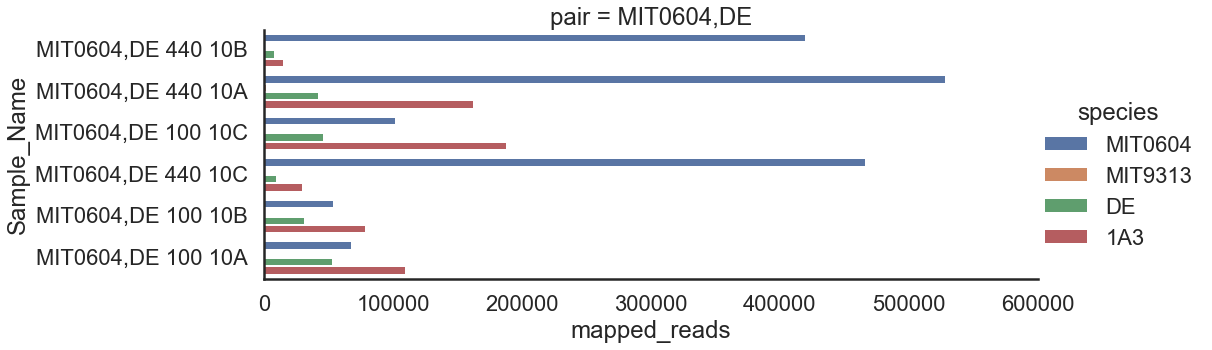

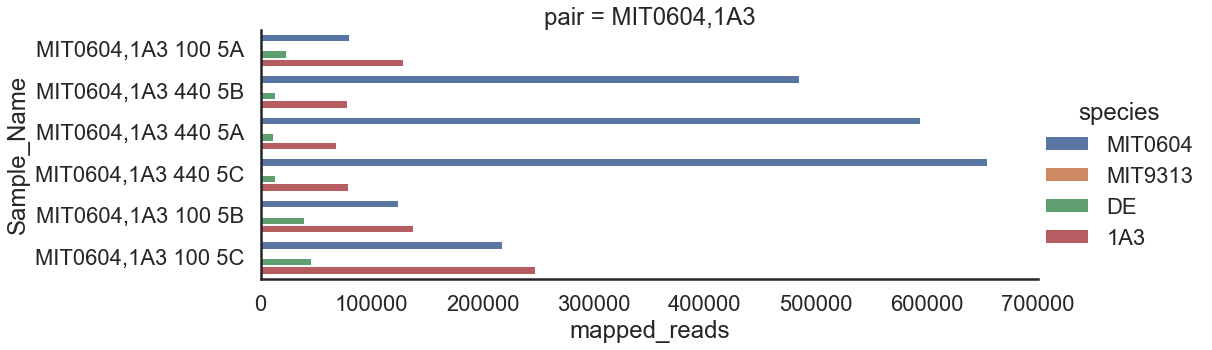

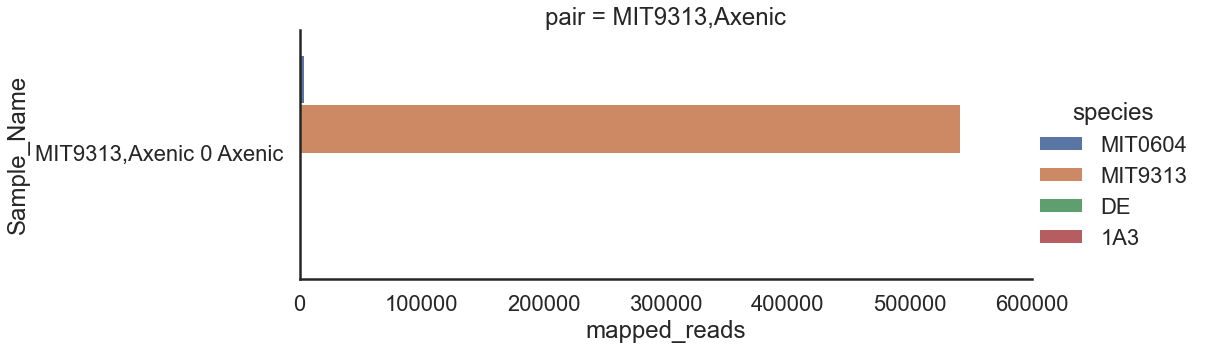

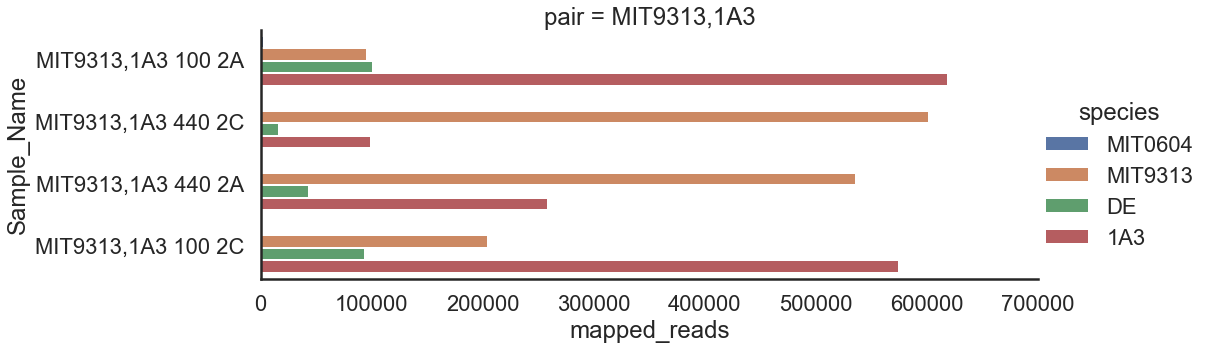

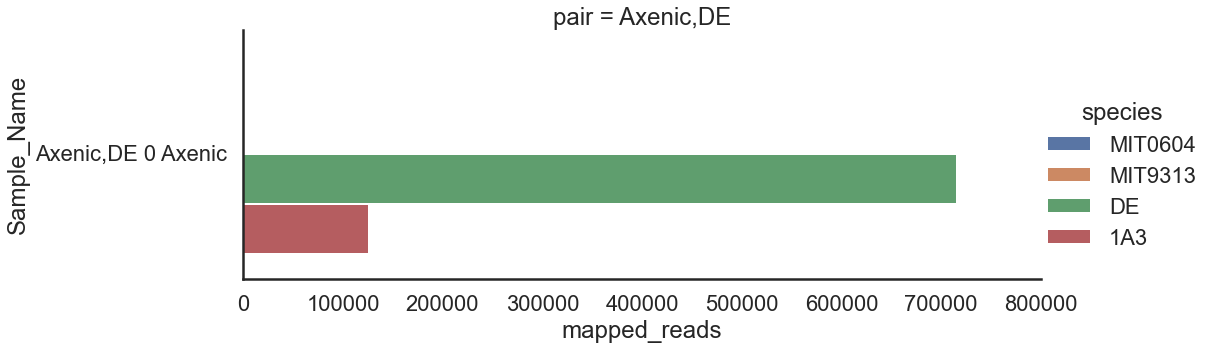

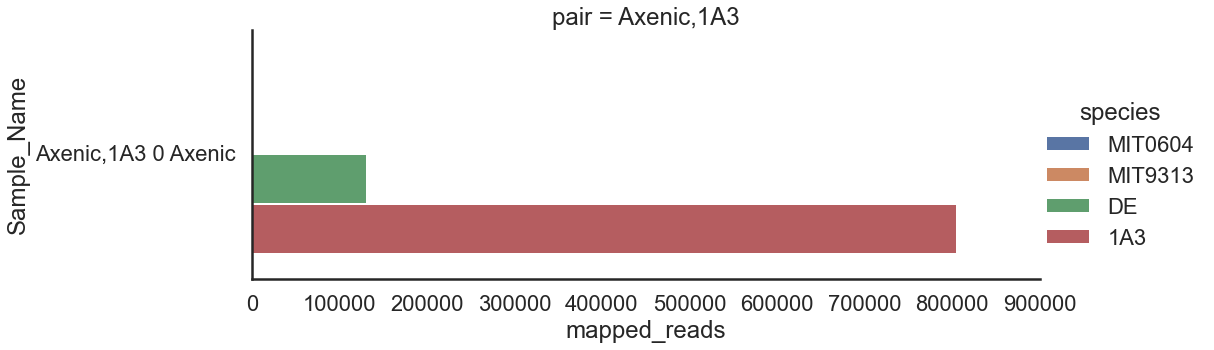

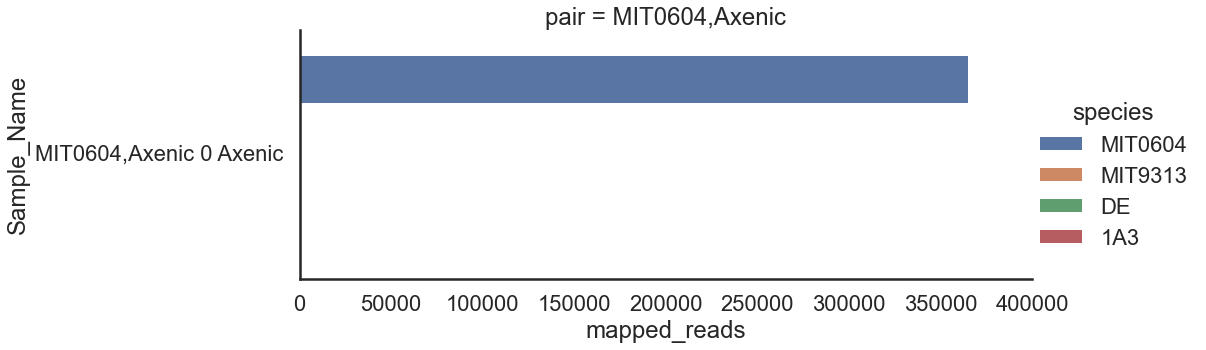

In [32]:
for i in trimmed_df['pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='mapped_reads', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
#plt.title(i)


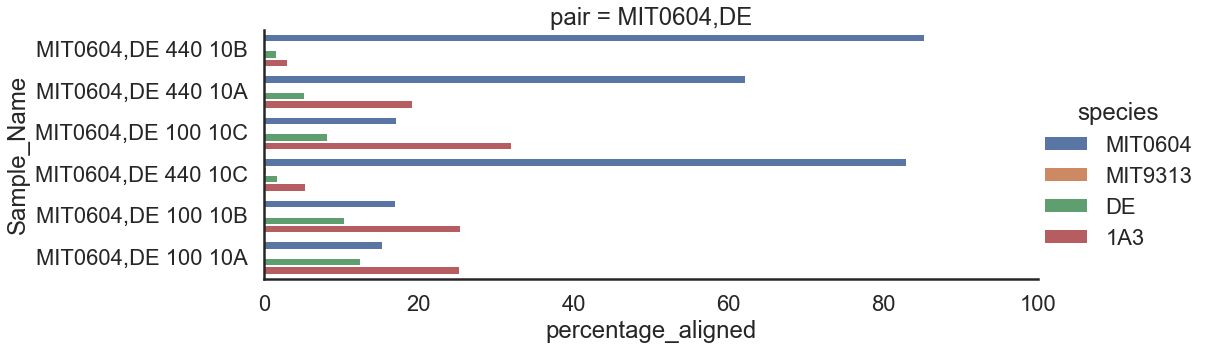

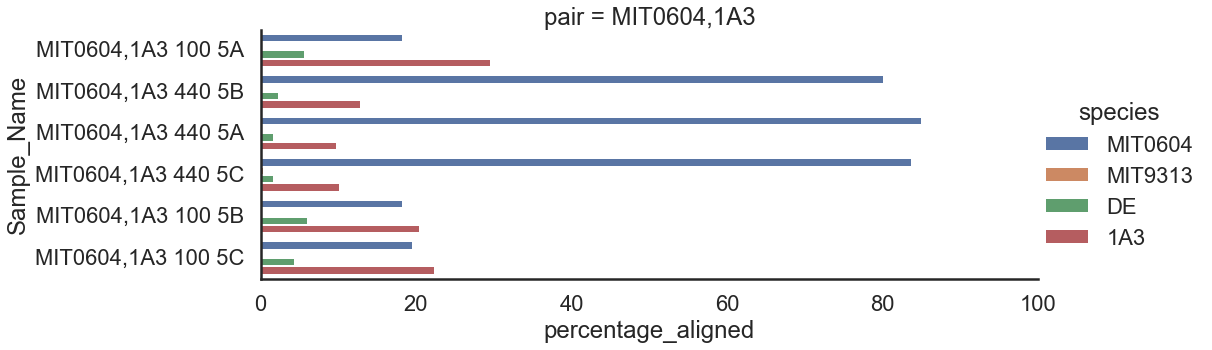

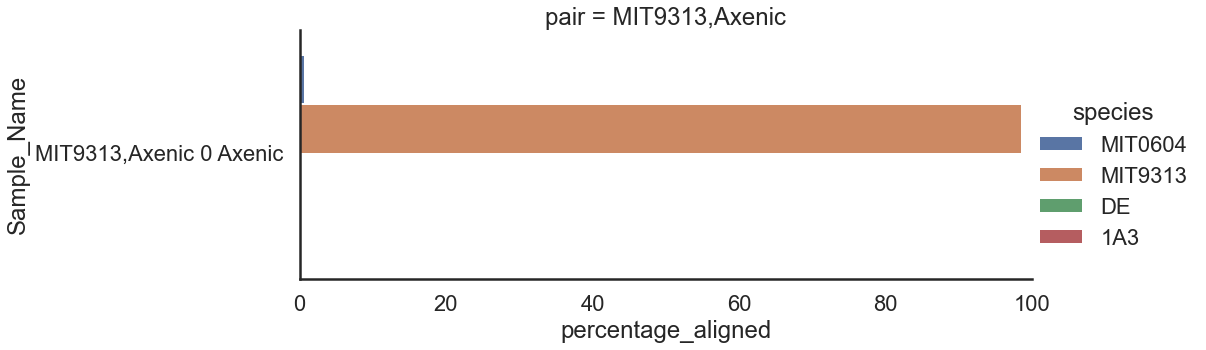

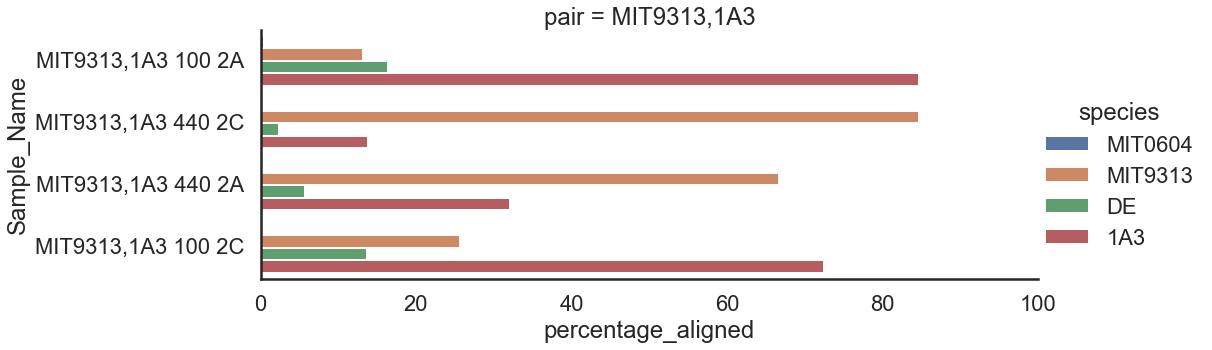

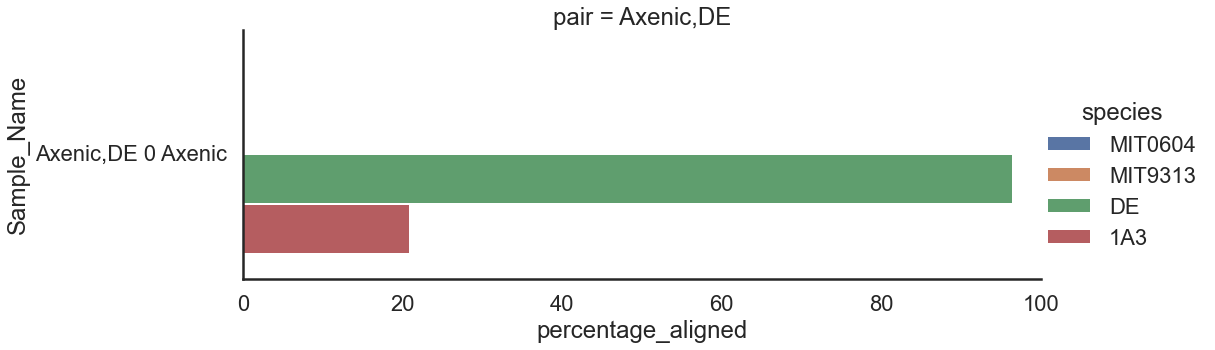

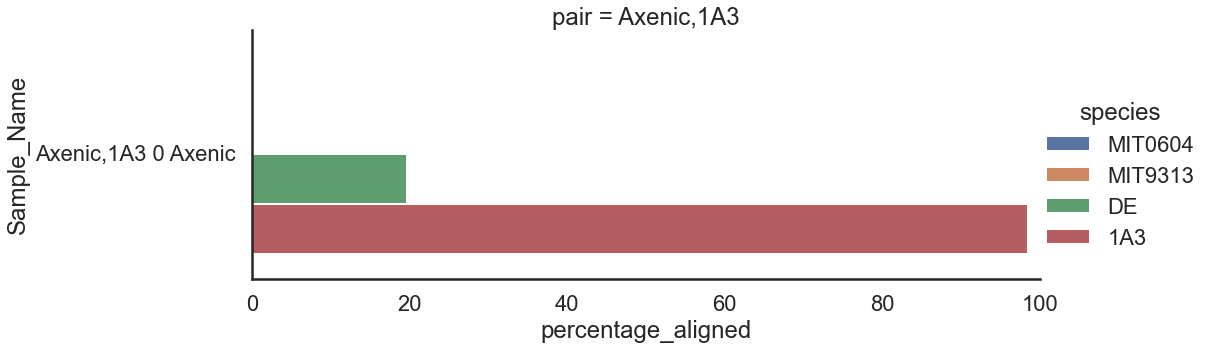

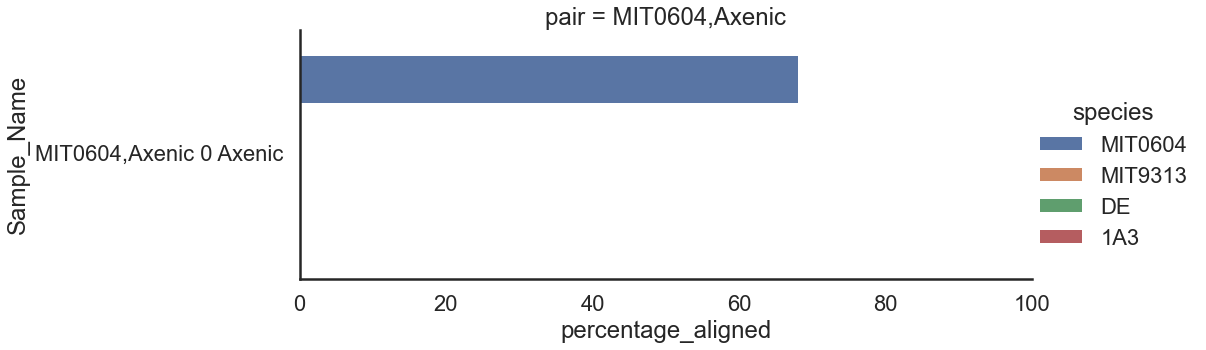

In [33]:
for i in trimmed_df['pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'all')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='percentage_aligned', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
    plt.xlim(0,100)
    plt.show()
#plt.title(i)


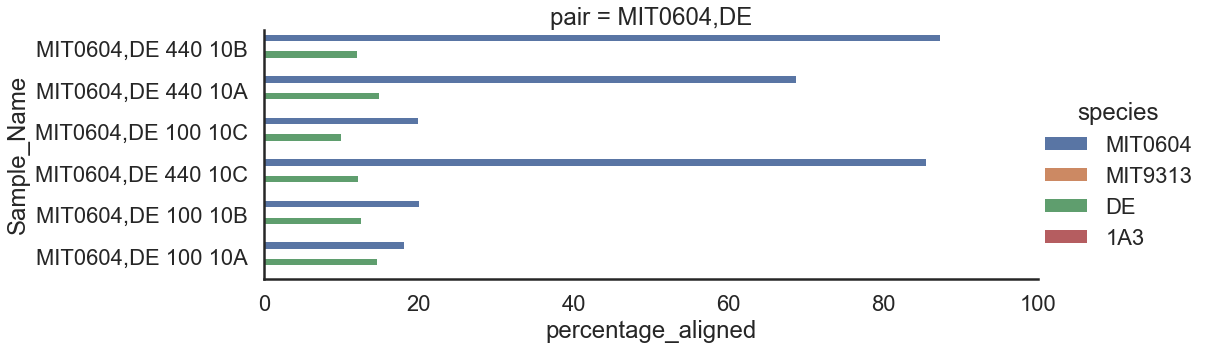

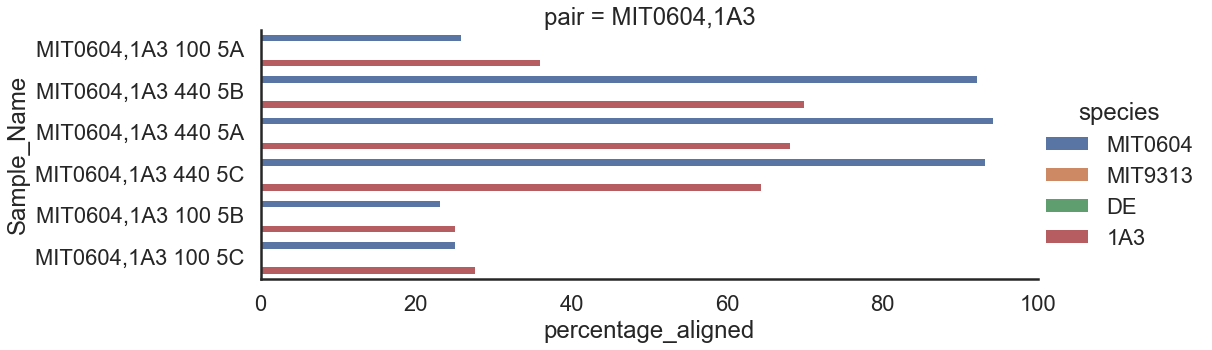

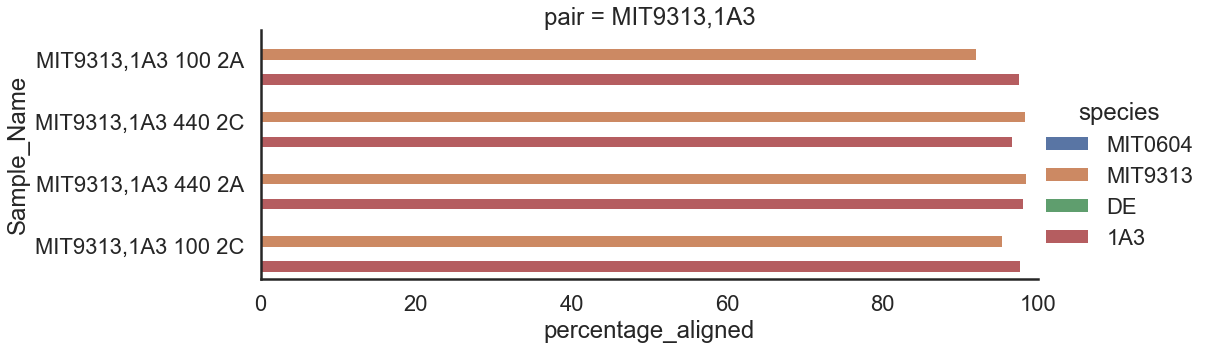

In [34]:
for i in trimmed_df.loc[(trimmed_df['sample'] != 'Axenic'),'pair'].dropna().unique():

    g = sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc') & (trimmed_df['mode'] == 'filtered')
                                    & (trimmed_df['pair'] == i)
                                   ],
                y='Sample_Name', x='percentage_aligned', 
               hue='species', hue_order=['MIT0604', 'MIT9313', 'DE', '1A3'],
                row='pair', sharex=False,
               aspect=3, kind='bar')
    plt.xlim(0,100)
    plt.show()
#plt.title(i)


In [35]:
trimmed_df.head().T

0                   1  \
total_reads                   488749.0             65170.0   
mapped_reads                    8101.0              7893.0   
percentage_aligned            1.657497           12.111401   
general_error_rate                2.13                 2.1   
mean_coverage                   0.2863              0.2794   
...                                ...                 ...   
days                               440                 440   
ng/ul                             6.25                6.25   
final volume                       100                 100   
pair                        MIT0604,DE          MIT0604,DE   
Sample_Name         MIT0604,DE 440 10B  MIT0604,DE 440 10B   

                                     2                   3                   4  
total_reads                   489657.0            489977.0            491414.0  
mapped_reads                   15149.0              1455.0            420148.0  
percentage_aligned            3.093798            0.296953           85.497768  
general_error_rate                2.02                3.89                0.09  
mean_coverage                   0.5048              0.0886              38.419  
...                                ...                 ...                 ...  
days                               440                 440                 440  
ng/ul                             6.25                6.25                6.25  
final volume                       100                 100                 100  
pair                        MIT0604,DE          MIT0604,DE          MIT0604,DE  
Sample_Name         MIT0604,DE 440 10B  MIT0604,DE 440 10B  MIT0604,DE 440 10B  

[121 rows x 5 columns]

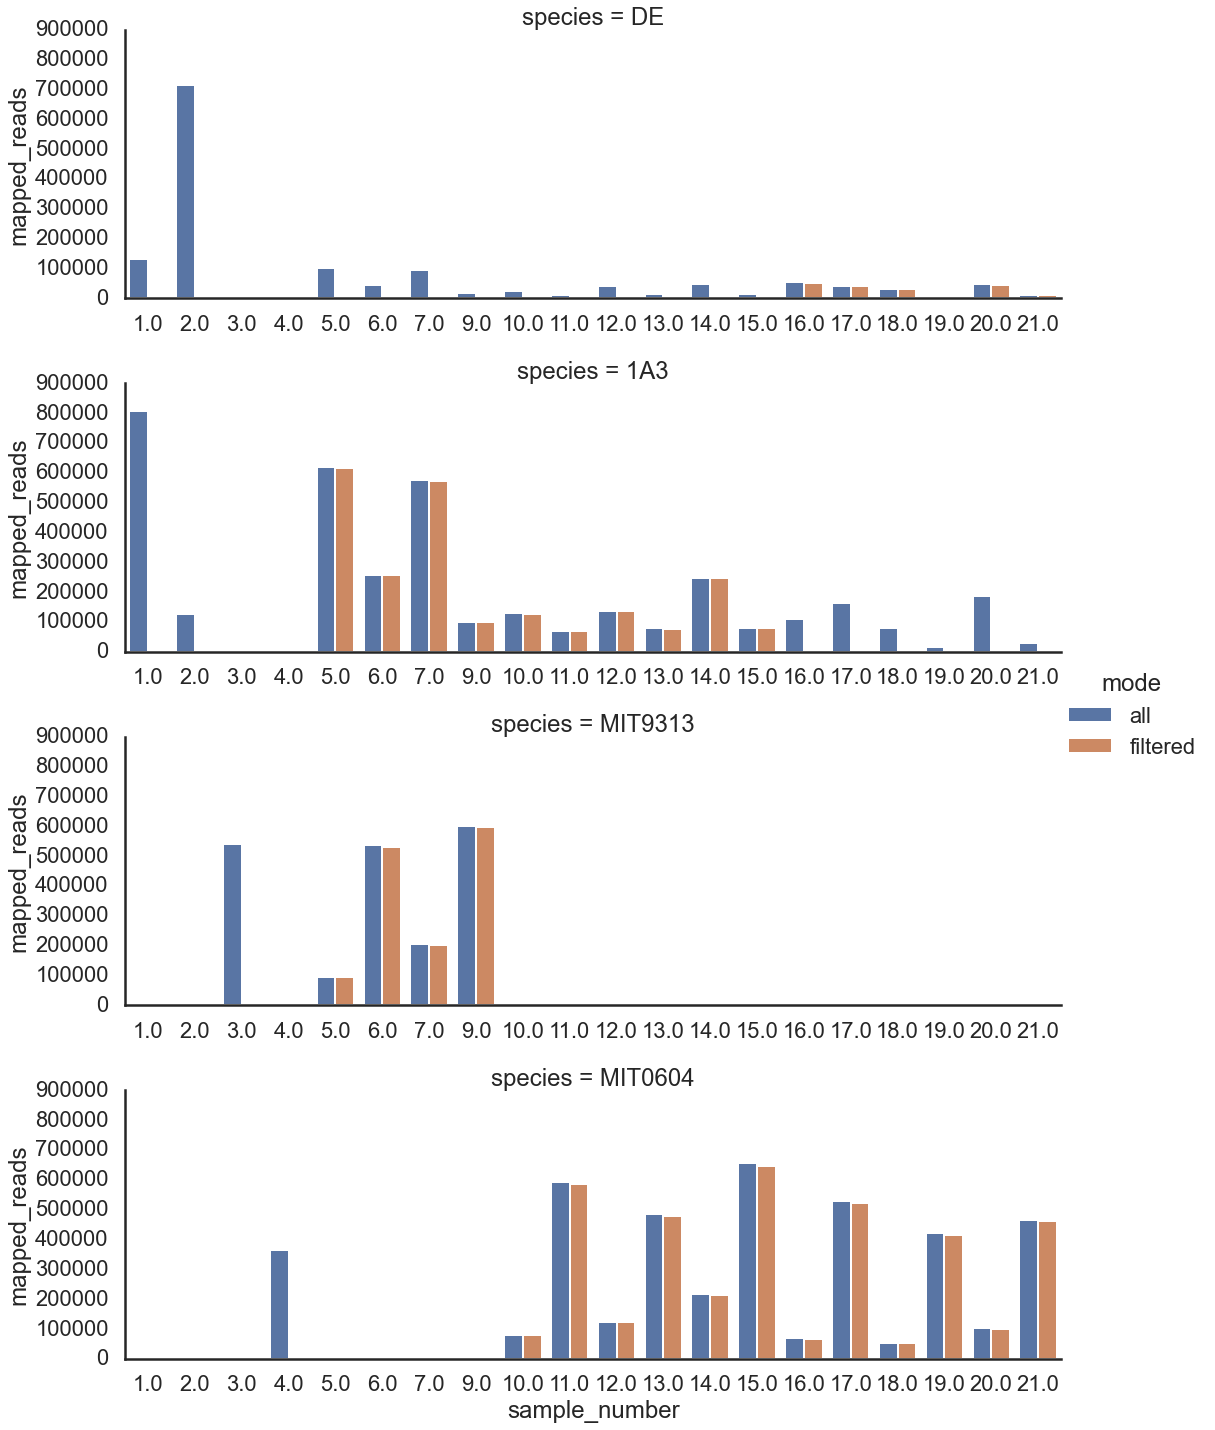

In [36]:
# pd.options.display.float_format = '{:d}'.format
sns.catplot(data=trimmed_df.loc[(trimmed_df['command'] == 'bamqc')],
            x='sample_number', y='mapped_reads', 
           row='species', hue='mode', sharex=False,
           aspect=3, kind='bar')

In [37]:
 trimmed_df.sample_number.dtypes

dtype('float64')

In [38]:
bamqc_df['trim'] = 'adapter'
trimmed_df['trim'] = 'Q>20'
pd.options.display.float_format = '{:.0f}'.format

merged_stat_df = pd.concat([
    bamqc_df.loc[~bamqc_df.species.isin(['Maricaulis '])], 
    trimmed_df.loc[
        (trimmed_df['command'] == 'bamqc') & 
        ((trimmed_df['mode'] == 'filtered') |
         ((trimmed_df['sample_number'] < 5)  & 
          (trimmed_df.PRO == trimmed_df.species) | (trimmed_df.ALT == trimmed_df.species)))
                                            ] 
                                            ],
        )

In [39]:
merged_stat_df.species = merged_stat_df.species.str.strip()

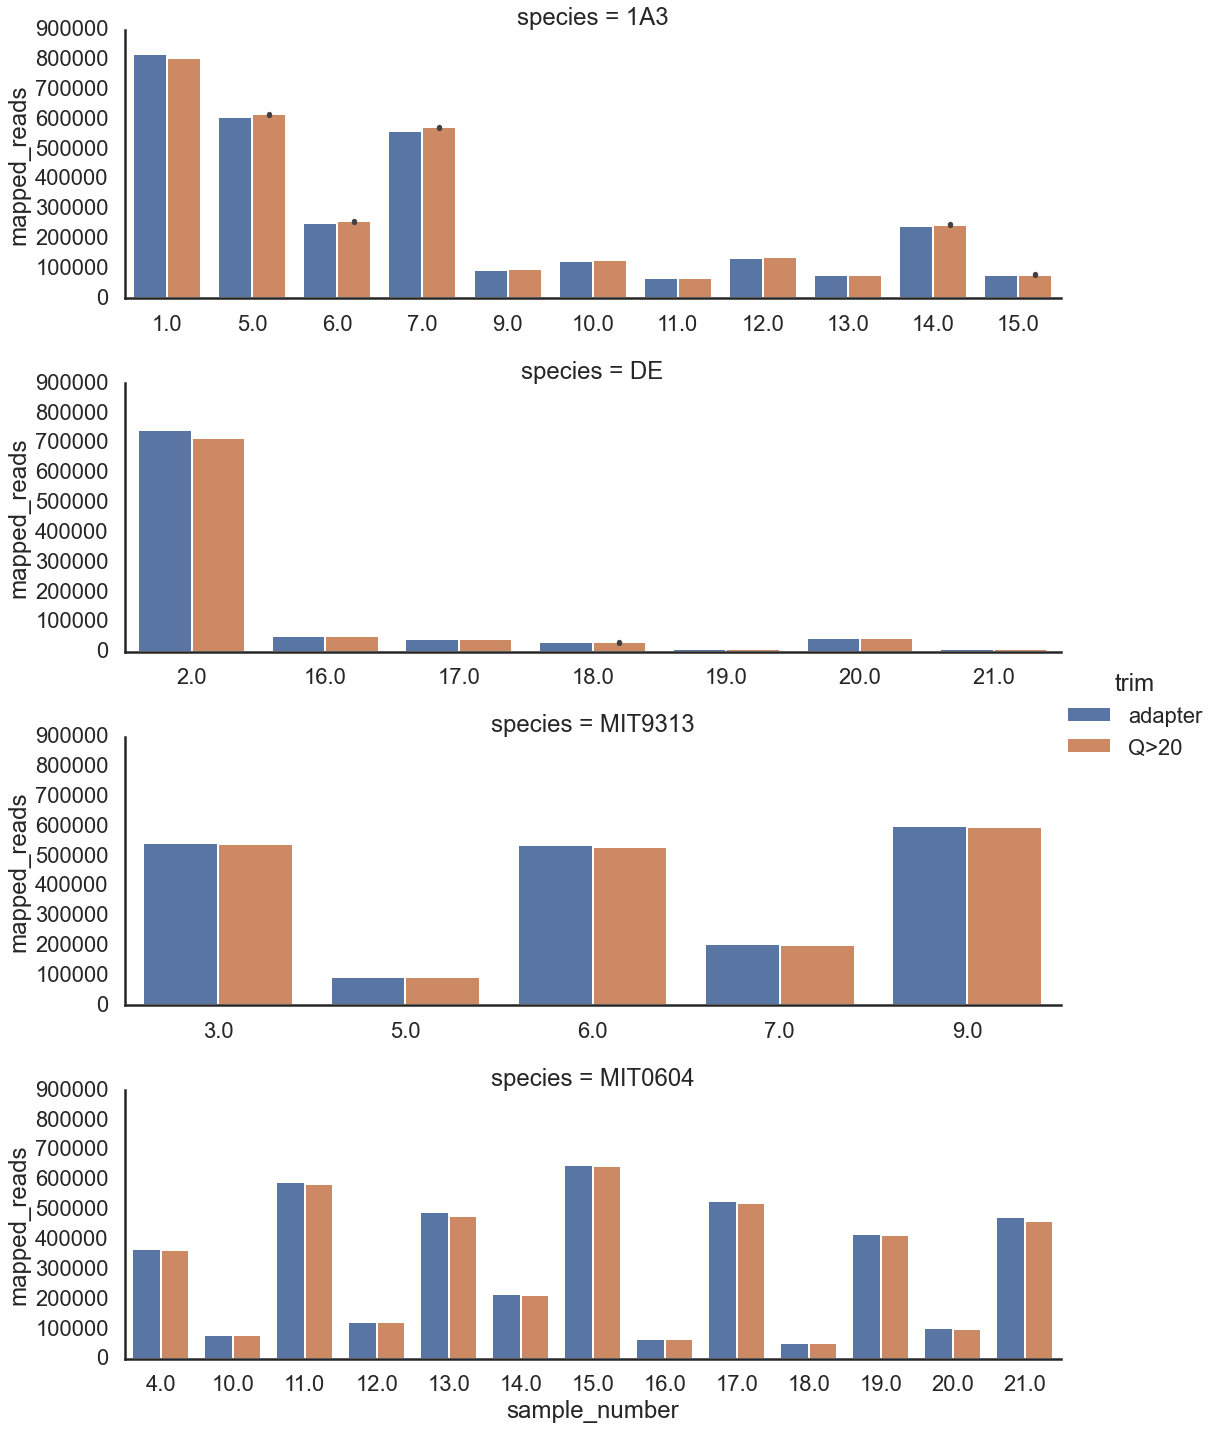

In [40]:
sns.catplot(data=merged_stat_df,
            x='sample_number', y='mapped_reads', 
           row='species', hue='trim', sharex=False,
           aspect=3, kind='bar')

Text(0.5, 1, 'mapped reads')

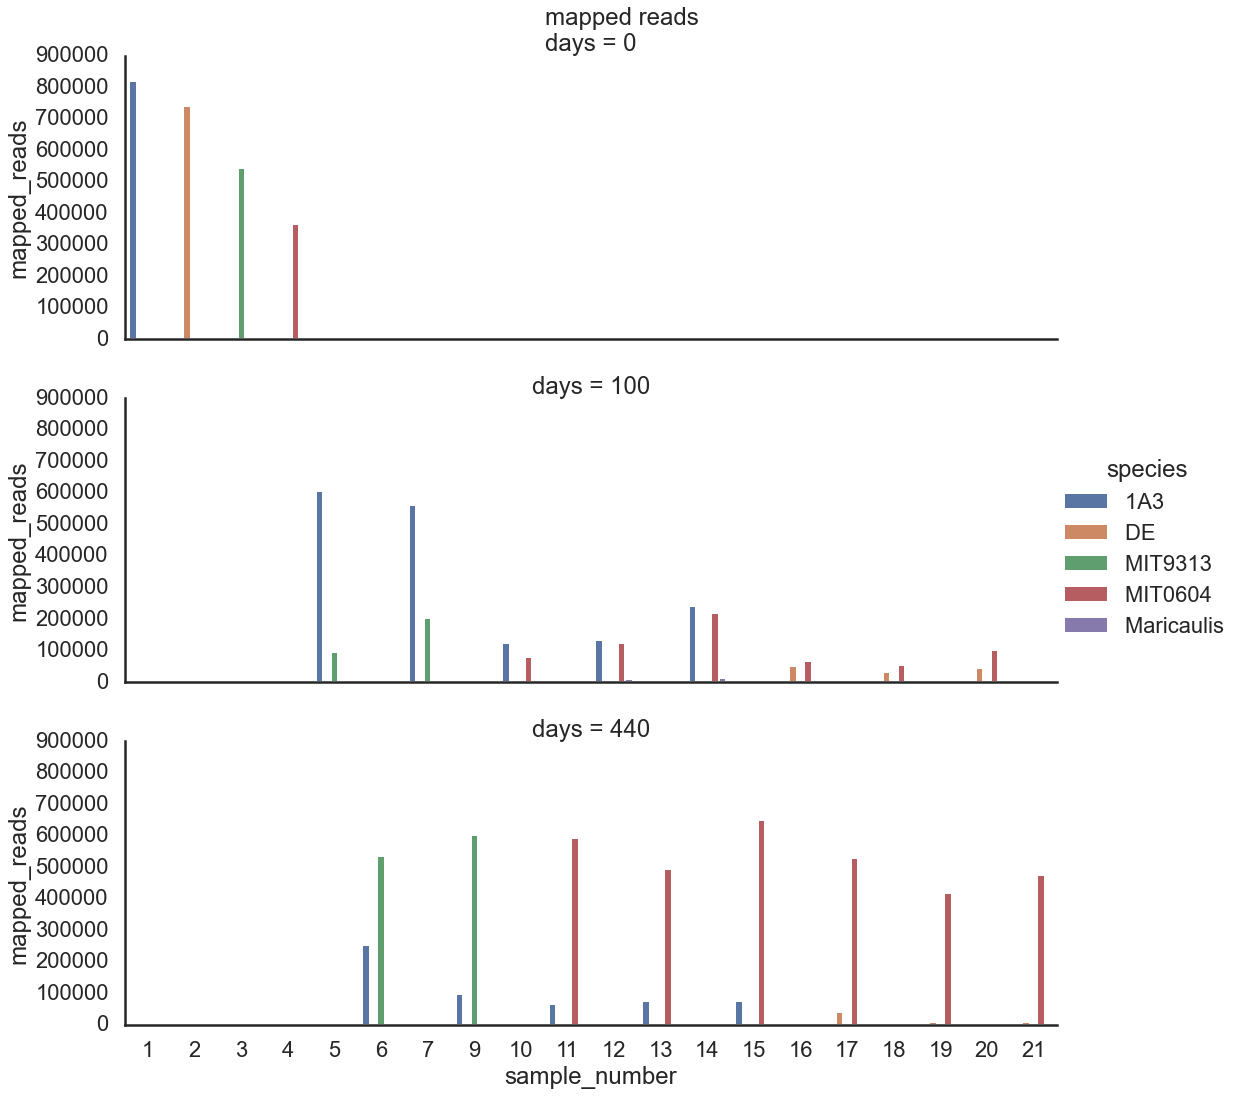

In [41]:
sns.set_style('white')
sns.set_context('poster')
sns.catplot(data=bamqc_df, x='sample_number', y='mapped_reads',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('mapped reads', y=1)

Text(0.5, 1, '% cov > 10x')

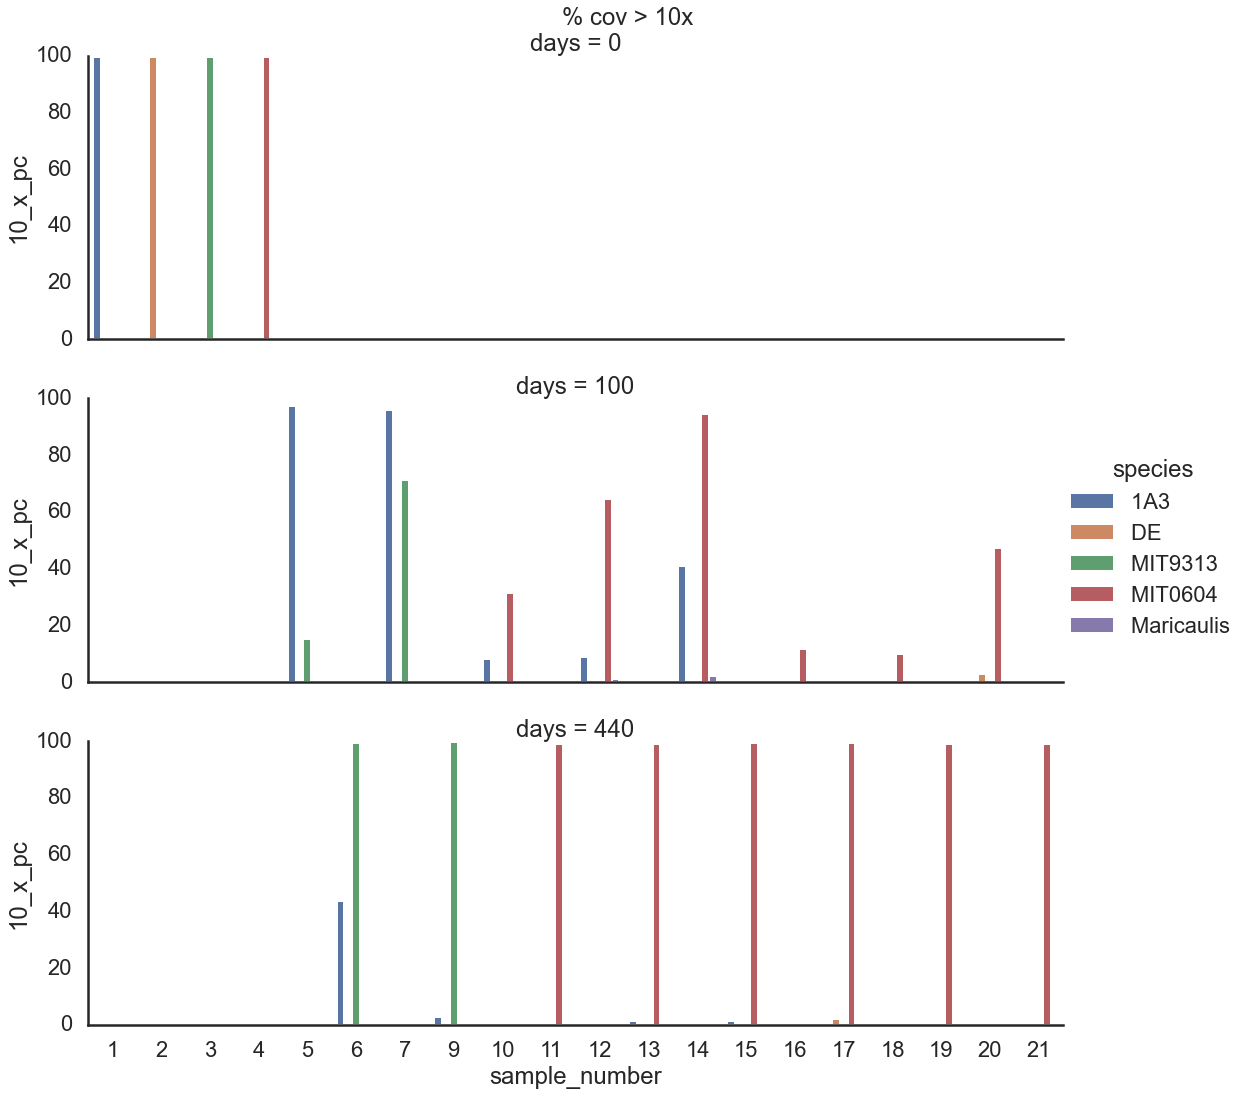

In [42]:
sns.set_style('white')
#sns.set_context('paper')
sns.catplot(data=bamqc_df, x='sample_number', y='10_x_pc',hue='species', row='days', 
            kind='bar', aspect=3)
plt.suptitle('% cov > 10x', y=1)

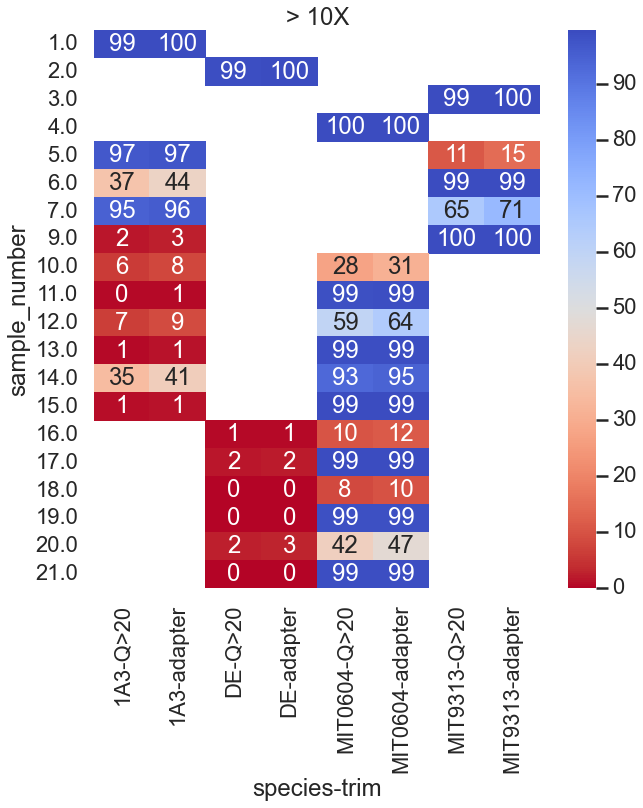

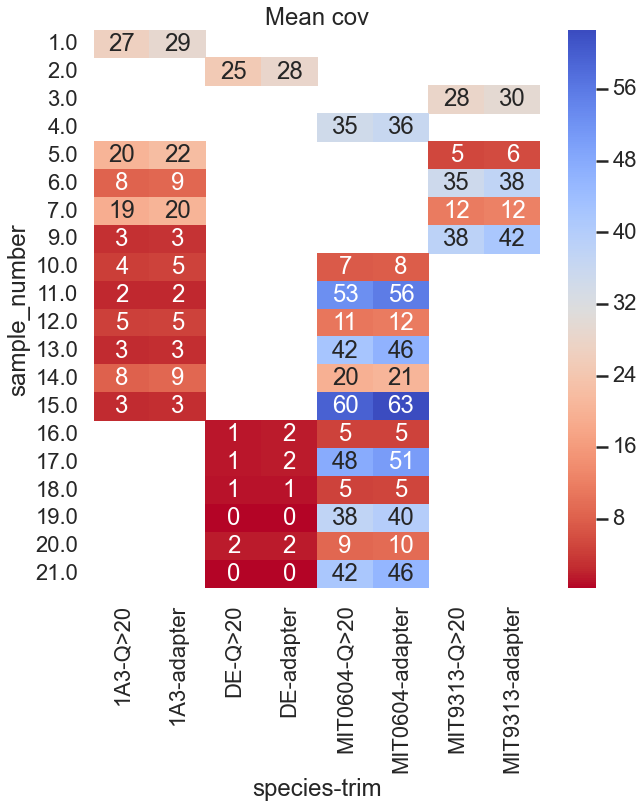

In [43]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.pivot_table(index='sample_number', columns=['species', 'trim'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

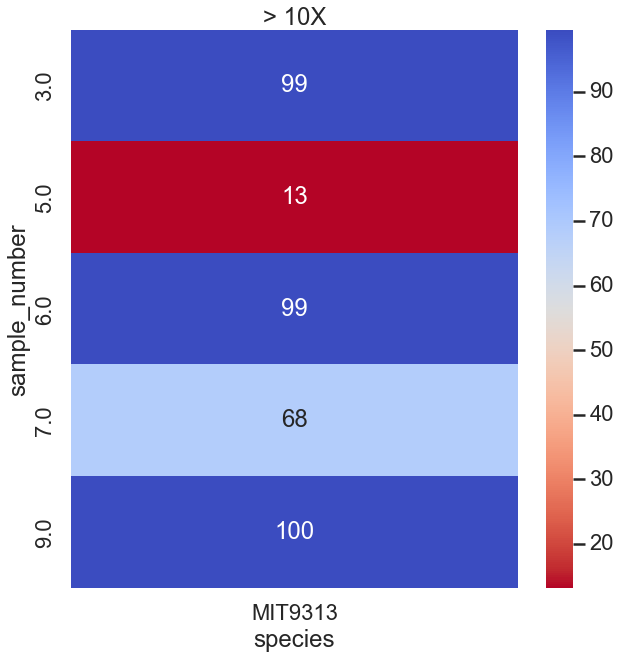

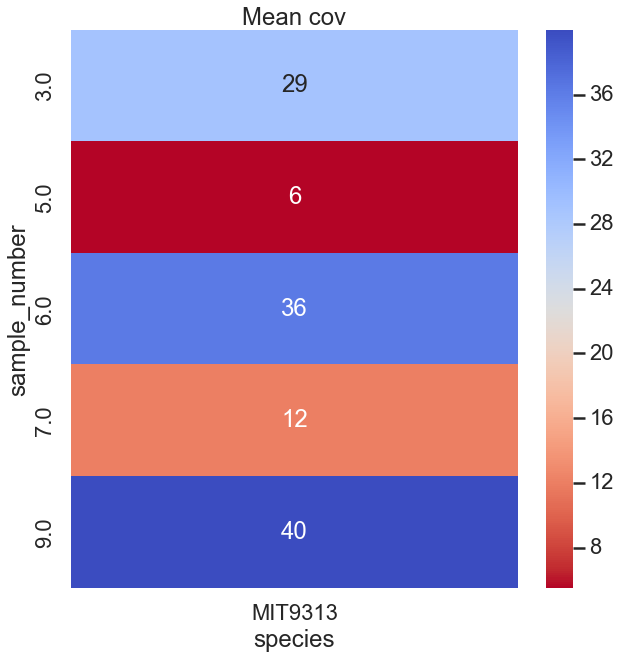

In [44]:
sns.set_context('poster')
value_cols = [  '10_x_pc',
         'mean_coverage',
              #'mapped_reads'
             ]

for v in value_cols:
    # 'sample', 'PRO', 'ALT', 'exp',
    plt.figure(figsize=(10,10))
    
    bamqc_pdf = merged_stat_df.loc[merged_stat_df['species'].isin(['MIT9313'])].pivot_table(index='sample_number', columns=['species'], 
                           values=[v]).droplevel(level=0, axis='columns')
    #bamqc_pdf[pct_cols] = bamqc_pdf[pct_cols]/100
    #bamqc_pdf.rename(columns=qmap_titles, inplace=True)
    sns.heatmap(bamqc_pdf, cmap='coolwarm_r',
                  annot=True, fmt='.0f')
    plt.title(qmap_titles[v])
    plt.show()

In [45]:
merged_stat_df.columns.unique()

Index(['Key', '10_x_pc', '1_x_pc', '30_x_pc', '50_x_pc', '5_x_pc', 'avg_gc',
       'general_error_rate', 'mapped_reads', 'mean_coverage',
       ...
       'dropped_pct', 'percent_gc', 'avg_sequence_length', 'total_sequences',
       'percent_duplicates', 'percent_fails', 'mode', 'command', 'pair',
       'Sample_Name'],
      dtype='object', length=122)

In [46]:
#from glob import glob
#data_dpath = os.path.join('DNA','freebayes')
data_dpath = os.path.join('DNA','dnaseq_trimmed')
# ##INFO=<ID=ANN,Number=.,Type=String,
#Description="Functional annotations: 'Allele | Annotation | Annotation_Impact | 
#            Gene_Name | Gene_ID | Feature_Type | Feature_ID | Transcript_BioType | 
#              Rank | HGVS.c | HGVS.p | 
# cDNA.pos / cDNA.length | CDS.pos / CDS.length | AA.pos / AA.length | Distance | ERRORS / WARNINGS / INFO' ">
def _parse_csv(t):
    ANN_columns = [
        'Allele', 'Annotation',  'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
        'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p', 'cDNA.pos',  'CDS.pos', 
        'AA.pos', 'Distance', 'ERRORS'
    ]
    #idx = 160000+i
    #dname = f'D20-{idx}-4500T'
    #glob(os.path.join(data_dpath, dname,'**', '*.csv'), recursive=True)
    fpath = os.path.join(data_dpath, #f'freebayes_{t}',
                         f'freebayes_{t}.tab')
    df =  pd.read_csv(fpath, sep='\t') 
    df['species'] = t
    df.ANN = df.ANN.str.split(',')
    df = df.apply( pd.Series.explode )


    df[ANN_columns] = df['ANN'].str.split('|', expand=True)
    df = df.drop('ANN', axis=1)
    return df

df_MIT9313 = _parse_csv('MIT9313') 
df_MIT0604 = _parse_csv('MIT0604') 
df_DE = _parse_csv('DE') 
df_1A3 = _parse_csv('1A3') 


In [47]:
def parse_freebayes(genome):
    df_s =  _parse_csv(genome) 
    id_vars=['CHROM', 'POS', 'TYPE', 'REF', 'ALT', 
       'species', 'Allele', 'Annotation', 'Impact', 'Gene_Name', 'Gene_ID',
       'Feature_Type', 'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c',
       'HGVS.p', 'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS']


    d = df_s.melt(id_vars=id_vars)
    d['variable'] = d['variable'].str.replace('D20-1600', '')
    d[['sample_number', 'variable']] = d['variable'].str.split('.',expand=True)
    d['sample_number'] = pd.to_numeric(d['sample_number'])

    pdf = d.pivot_table(index=(id_vars+['sample_number']), columns=['variable'], aggfunc='first', #values='value',
                   ).droplevel(level=0, axis='columns').reset_index() 
    
    pdf['good_call'] = (pdf.DP > 10) & (pdf.GQ > 20)
    mask = (~pdf.AO.astype(str).str.contains(',', na=False, regex=False) & 
            ~pdf.DP.astype(str).str.contains(',', na=False, regex=False) &
            (pdf['DP'] != 0) & pdf['good_call'])
    try: 
        pdf.loc[mask, 'fraction_Alt'] = pdf.loc[mask, 'AO'] / pdf.loc[mask, 'DP']
    except Exception:
        pdf['fraction_Alt'] = ''

    
    pdf['culture'] = 'Co_Culture'
    pdf.loc[pdf['sample_number']<=4, 'culture'] = 'Axenic'
    
    df_genome = pd.read_pickle(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.pkl.gz'))
    #df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
    #                          sheet_name='9313+1A3')
    genome_cols = ['gene_id', 'pmt_id', 'type',  'strand', 
       'product', 'protein_id']
    mpdf = pd.merge(pdf, 
                    df_genome[genome_cols], left_on='Gene_Name', right_on='gene_id', 
                    how='left'
                   )
    #mpdf[['PMTID1', 'PMTID2']] = mpdf.pmt_id.str.split(',', expand=True)
    mpdf = pd.merge(mpdf, meta_df, on='sample_number', how='left')
    mpdf['good_call'] = (mpdf.DP > 10) & (mpdf.GQ > 20)
    mpdf.loc[mpdf.good_call & (mpdf.ALT_x == mpdf.GT), 'call'] = 1
    mpdf.loc[mpdf.good_call & (mpdf.REF == mpdf.GT), 'call'] = 0
    mpdf.loc[mpdf.good_call & (mpdf.REF != mpdf.GT) & (mpdf.ALT_x != mpdf.GT), 'call'] = -1
    return mpdf

In [48]:
genome='MIT9313'
df_genome = pd.read_pickle(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.pkl.gz'))
df_genome.head()


contig_id        gene_id            pmt_id type       location strand  \
0   MIT9313  AKG35_RS00005  PMT0001,PMT_0001  CDS  AKG35_RS00005      +   
1   MIT9313  AKG35_RS00010  PMT0002,PMT_0002  CDS  AKG35_RS00010      +   
2   MIT9313  AKG35_RS00015  PMT0003,PMT_0003  CDS  AKG35_RS00015      +   
3   MIT9313  AKG35_RS00020  PMT0004,PMT_0004  CDS  AKG35_RS00020      +   
4   MIT9313  AKG35_RS00025  PMT0005,PMT_0005  CDS  AKG35_RS00025      -   

   start  stop  left  right  \
0    173  1340   173   1340   
1   1343  2120  1343   2120   
2   2177  4562  2177   4562   
3   4621  6079  4621   6079   
4   6114  8604  6114   8604   

                                            function   genome  \
0                    DNA polymerase III subunit beta  MIT9313   
1                               hypothetical protein  MIT9313   
2  phosphoribosylformylglycinamidine synthase sub...  MIT9313   
3                     amidophosphoribosyltransferase  MIT9313   
4                      DNA topoisomerase 4 subunit A  MIT9313   

                   old_locus_tag  \
0  PMT0001,PMT_0001,RG24_RS00005   
1  PMT0002,PMT_0002,RG24_RS00010   
2  PMT0003,PMT_0003,RG24_RS00015   
3  PMT0004,PMT_0004,RG24_RS00020   
4  PMT0005,PMT_0005,RG24_RS00025   

                                             product       db_xref  \
0                    DNA polymerase III subunit beta  GI:499441916   
1                               hypothetical protein  GI:752737102   
2  phosphoribosylformylglycinamidine synthase sub...  GI:499441918   
3                     amidophosphoribosyltransferase  GI:499441919   
4                      DNA topoisomerase 4 subunit A  GI:499441920   

       protein_id figfam nucleotide_sequence  \
0  WP_011129380.1                              
1  WP_041384224.1                              
2  WP_011129382.1                              
3  WP_011129383.1                              
4  WP_011129384.1                              

                                         aa_sequence  
0  MKLVCSQAELNTALQLVSRAVASRPTHPVLANVLLTADAGTDRLSL...  
1  MNLPDQILLSDLLHHRVRCDQGLDHGPGVLPWMHPPVHRLLGWVSR...  
2  MRVDYDVAAALRHEGLKPHDYDEICRRLQRAPNRVELGMFGVMWSE...  
3  MCGIVGIVSTALVNQQIYDSLLLLQHRGQDSTGIATMDGSVFHLHK...  
4  MAEERLQPIALHQEMQRSYLEYAMSVIVGRALPDARDGLKPVQRRI...

In [49]:
genome='MIT9313'
df_genome = pd.read_pickle(os.path.join('DNA', 'genomes',f'{genome}.ncbi.gb.pkl.gz'))
df_genome.columns

Index(['contig_id', 'gene_id', 'pmt_id', 'type', 'location', 'strand', 'start',
       'stop', 'left', 'right', 'function', 'genome', 'old_locus_tag',
       'product', 'db_xref', 'protein_id', 'figfam', 'nucleotide_sequence',
       'aa_sequence'],
      dtype='object')

In [50]:
df_genome.loc[df_genome['function'].str.contains('nitrite')]

contig_id        gene_id            pmt_id type       location strand  \
2423   MIT9313  AKG35_RS11935  PMT2239,PMT_2239  CDS  AKG35_RS11935      +   
2425   MIT9313  AKG35_RS11945  PMT2240,PMT_2240  CDS  AKG35_RS11945      +   

        start     stop     left    right  \
2423  2365138  2366767  2365138  2366767   
2425  2367030  2367921  2367030  2367921   

                                        function   genome  \
2423               ferredoxin--nitrite reductase  MIT9313   
2425  formate/nitrite transporter family protein  MIT9313   

                      old_locus_tag  \
2423  PMT2239,PMT_2239,RG24_RS11960   
2425  PMT2240,PMT_2240,RG24_RS11970   

                                         product       db_xref  \
2423               ferredoxin--nitrite reductase  GI:499444139   
2425  formate/nitrite transporter family protein  GI:499444140   

          protein_id figfam nucleotide_sequence  \
2423  WP_011131603.1                              
2425  WP_011131604.1                              

                                            aa_sequence  
2423  MVISSPAKQFLQGKKLNKIEQNKAFKDGLDVGDELENFAQLGWEQV...  
2425  MDYVLPNELVDGMITAGGKKSSVSIKNLLVRGFYSGAILGLATCLA...

In [51]:
dfs = dict()
for s in ['MIT0604', 'MIT9313', 'DE', '1A3']:
    dfs[s] = parse_freebayes(s)


In [52]:
df_DE_MIT9313 = pd.read_excel(os.path.join('DNA', 'genomes','41396_2016_BFismej201670_MOESM46_ESM.xlsx'),
                              sheet_name='9313+1A3')
df_DE_MIT9313.rename(columns={'log 2 fold change coculture/axenic' : 'log Fold Change'}, inplace=True)
de_cols = ['Synonym', 'q Value ', 'log Fold Change']
dfs['MIT9313'][['PMTID1', 'PMTID2']] = dfs['MIT9313'].pmt_id.str.split(',', expand=True)

dfs['MIT9313'] = pd.merge(dfs['MIT9313'], 
                df_DE_MIT9313[de_cols], left_on='PMTID1', right_on='Synonym', 
                how='left'
               )


In [53]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 'pmt_id', 'type', 'strand', 'product']
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', 'DP', 'AO', 'RO','GQ','GT',  ]
species= 'MIT9313'


condition_format_cols = {
    'MIT9313' : ['T7:X10000', 'Y7:AC10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'Y:AC',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = dfs[species].loc[dfs[species]['type'].isin(['CDS'])].fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('R:S', None, format1)
        worksheet.set_column('Q:Q', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


In [54]:
dfs[species].columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call'],
      dtype='object')

Text(0.5, 1.0, 'MIT9313 calls')

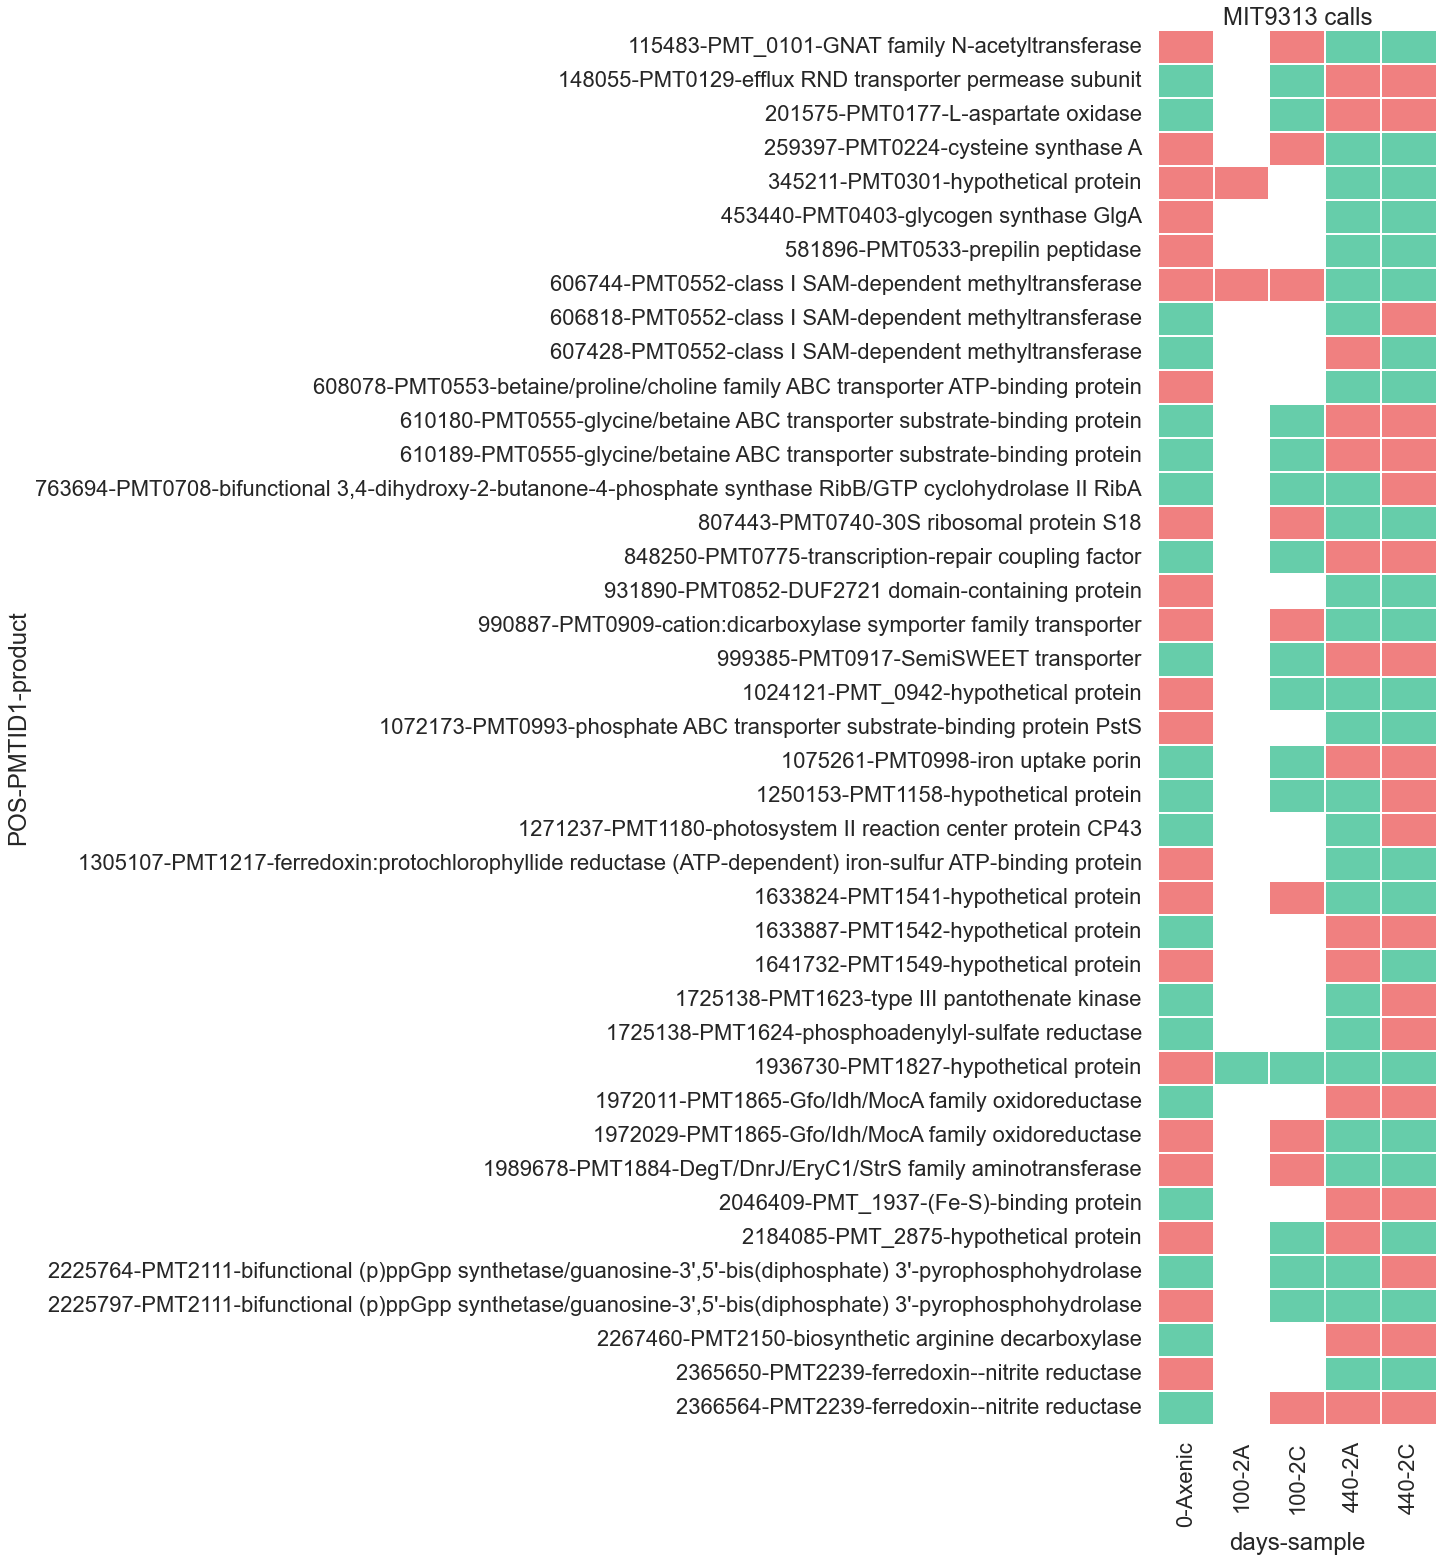

In [55]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['POS', 'PMTID1', 'product',], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

In [56]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf.loc[pvdf.std(axis=1) > 1e-1]
good_call_gene_ids = pvdf.loc[pvdf.std(axis=1) > 1e-1, 'gene_id']
dfs[species]['diff_snp'] = False
dfs[species].loc[dfs[species]['gene_id'].isin(good_call_gene_ids), 'diff_snp'] = True



In [57]:
'", "'.join(good_call_gene_ids)

'AKG35_RS12145", "AKG35_RS00645", "AKG35_RS00885", "AKG35_RS01190", "AKG35_RS01605", "AKG35_RS02150", "AKG35_RS02805", "AKG35_RS02910", "AKG35_RS03855", "AKG35_RS04035", "AKG35_RS04455", "AKG35_RS04770", "AKG35_RS04995", "AKG35_RS05290", "AKG35_RS05310", "AKG35_RS06205", "AKG35_RS06325", "AKG35_RS06510", "AKG35_RS08200", "AKG35_RS08205", "AKG35_RS08650", "AKG35_RS08655", "AKG35_RS09790", "AKG35_RS10080", "AKG35_RS12495", "AKG35_RS11235", "AKG35_RS11455", "AKG35_RS11935", "AKG35_RS09985", "AKG35_RS02915", "AKG35_RS03695", "AKG35_RS04825", "AKG35_RS11050", "AKG35_RS02925", "AKG35_RS08240'

In [58]:
dfs[species].head()

CHROM    POS   TYPE REF ALT_x  species Allele          Annotation  \
0  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
1  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
2  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
3  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   
4  NC_005071  66297  INDEL  GC     G  MIT9313      G  frameshift_variant   

  Impact      Gene_Name  ...   days  ng/ul final volume call   PMTID1  \
0   HIGH  AKG35_RS00340  ...      0      1          100    1  PMT0064   
1   HIGH  AKG35_RS00340  ...    100      1          100  NaN  PMT0064   
2   HIGH  AKG35_RS00340  ...    440      1          100    1  PMT0064   
3   HIGH  AKG35_RS00340  ...    100      2          100  NaN  PMT0064   
4   HIGH  AKG35_RS00340  ...  empty  empty        empty  NaN  PMT0064   

     PMTID2  Synonym q Value  log Fold Change diff_snp  
0  PMT_0064  PMT0064        1              -1    False  
1  PMT_0064  PMT0064        1              -1    False  
2  PMT_0064  PMT0064        1              -1    False  
3  PMT_0064  PMT0064        1              -1    False  
4  PMT_0064  PMT0064        1              -1    False  

[5 rows x 51 columns]

Text(0.5, 1.0, 'MIT0604 calls')

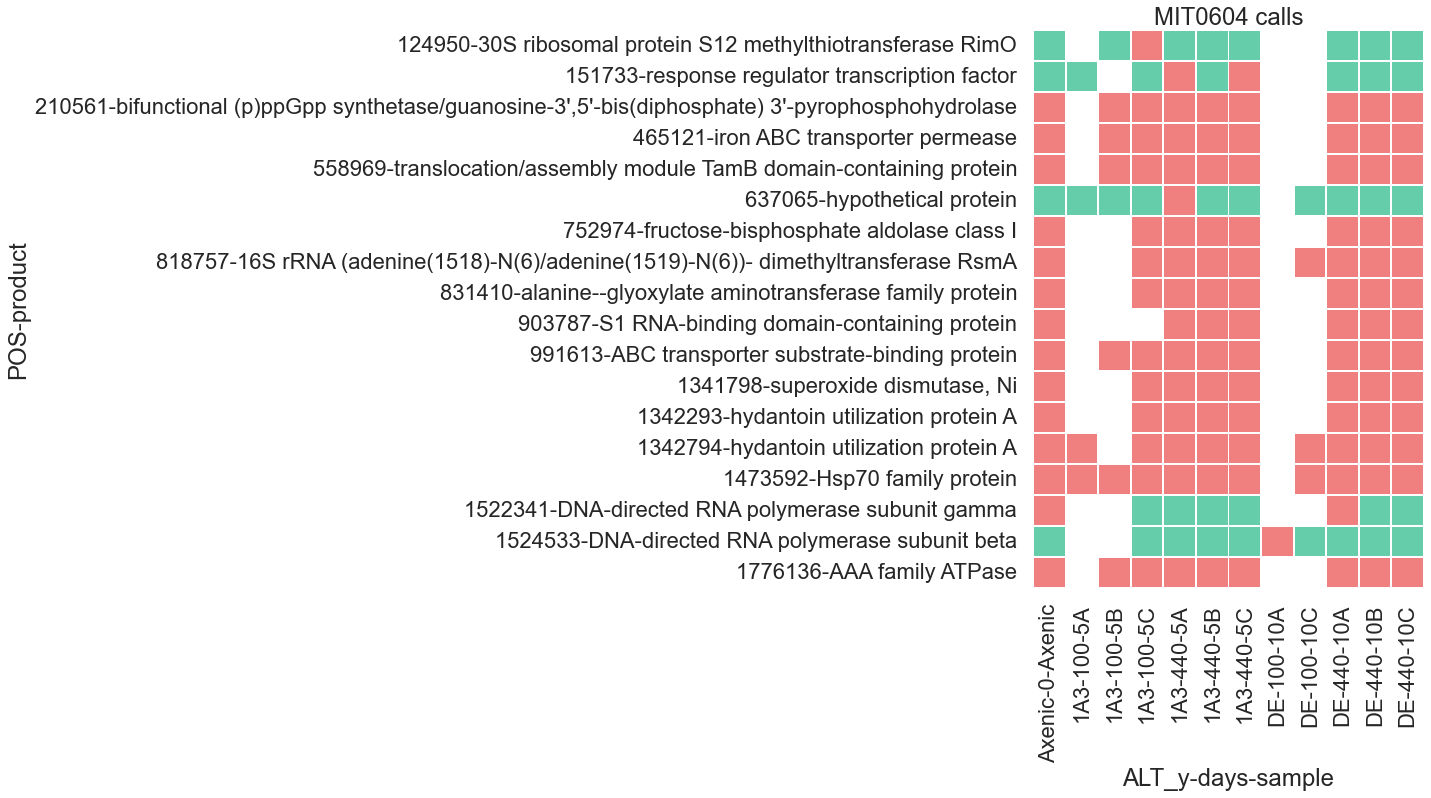

In [59]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

Text(0.5, 1.0, 'MIT0604 calls')

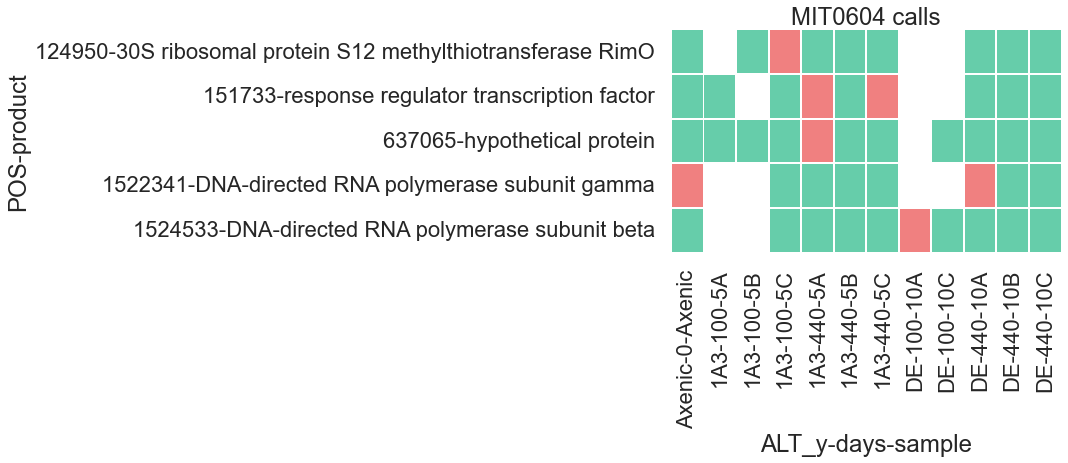

In [60]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=[ 'POS','product',], 
                                                columns=[ 'ALT_y', 'days','sample'], 
                                                                values='call', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values(( 0, 'Axenic','Axenic', )),
            cmap=['MediumAquamarine', 'lightcoral'],
            linewidths=1, linecolor='white', cbar=False)
plt.title(f'{species} calls')

In [61]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)].Gene_Name.nunique()

67

Text(0.5, 1.0, 'Fraction of Alternate Allele')

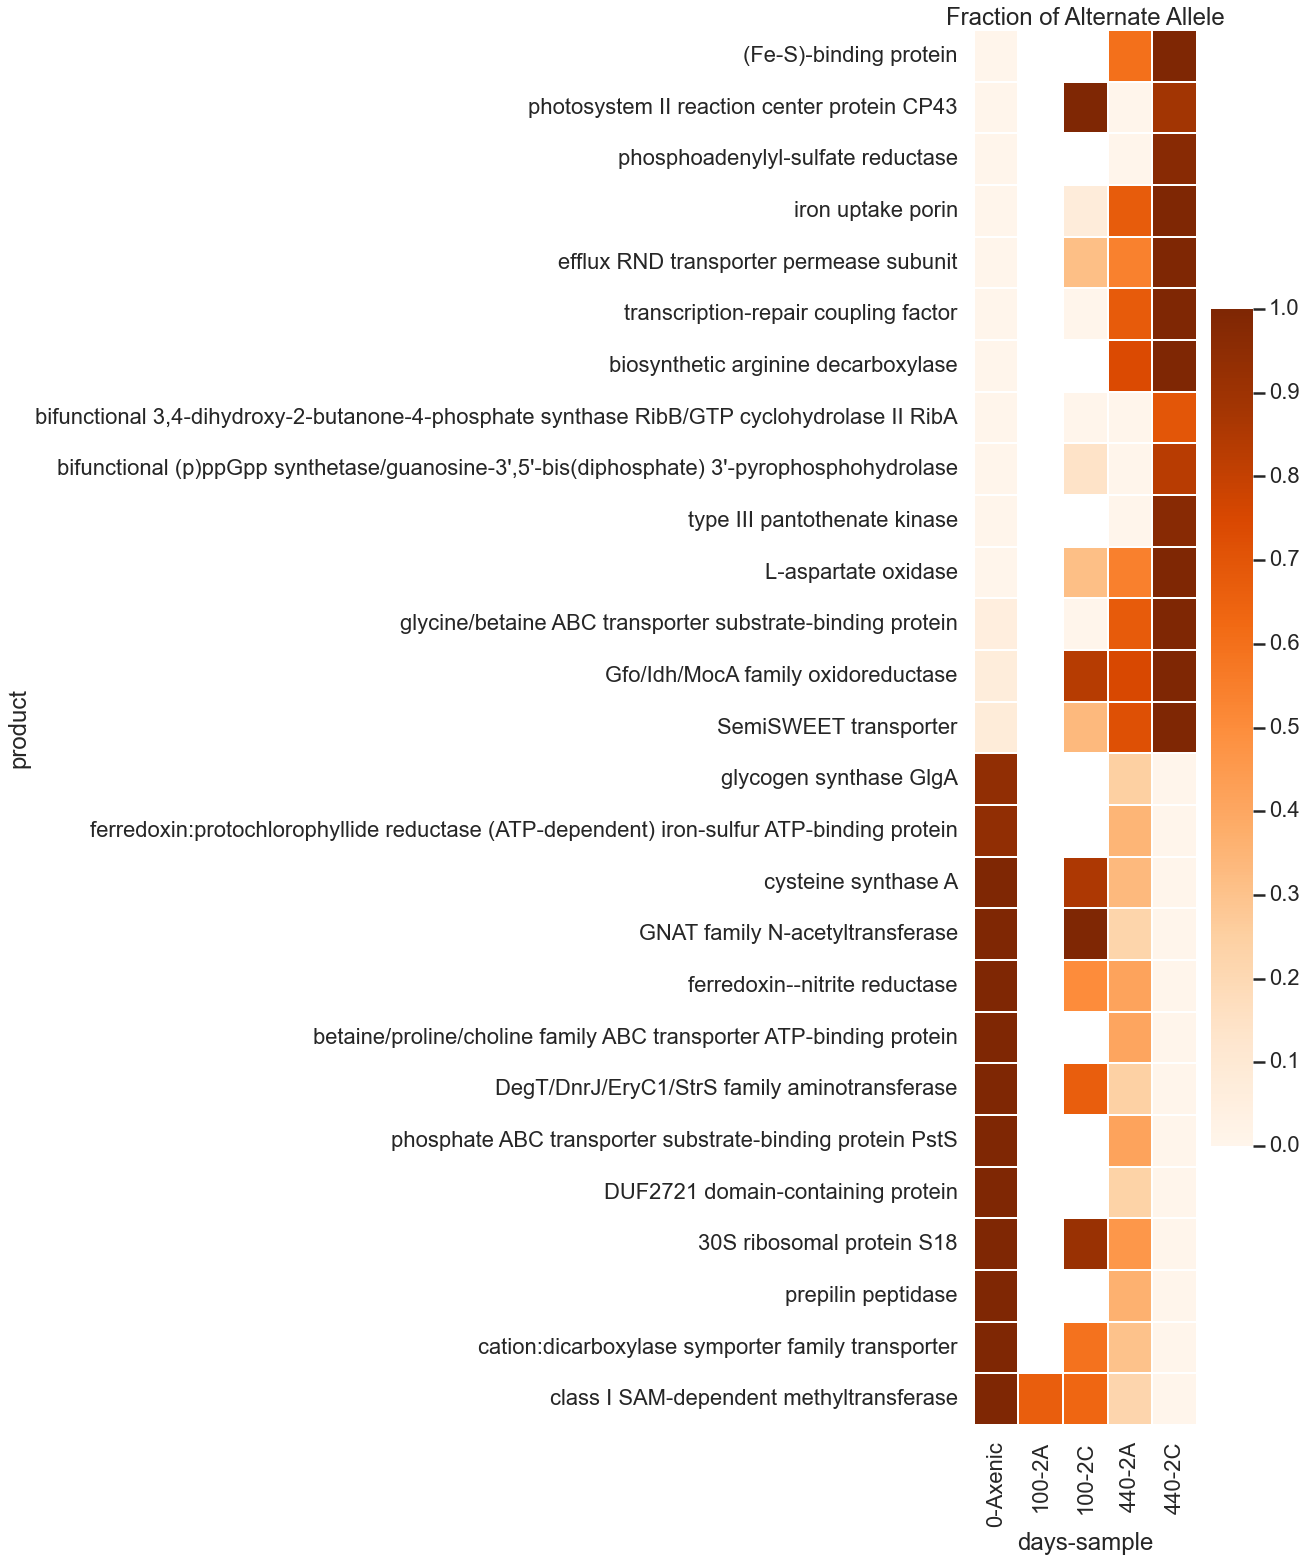

In [62]:
species = 'MIT9313'
plt.figure(figsize=(5,25))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=['product',], # 'POS', 'PMTID1','product',], 
                                                columns=[ 'days','sample',], values='fraction_Alt', aggfunc='first')
#pvdf.index = [f'{col[0]} : {col[1]} - {col[2]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1].sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title('Fraction of Alternate Allele')

Text(0.5, 1.0, 'MIT0604: fraction of Alternate Allele')

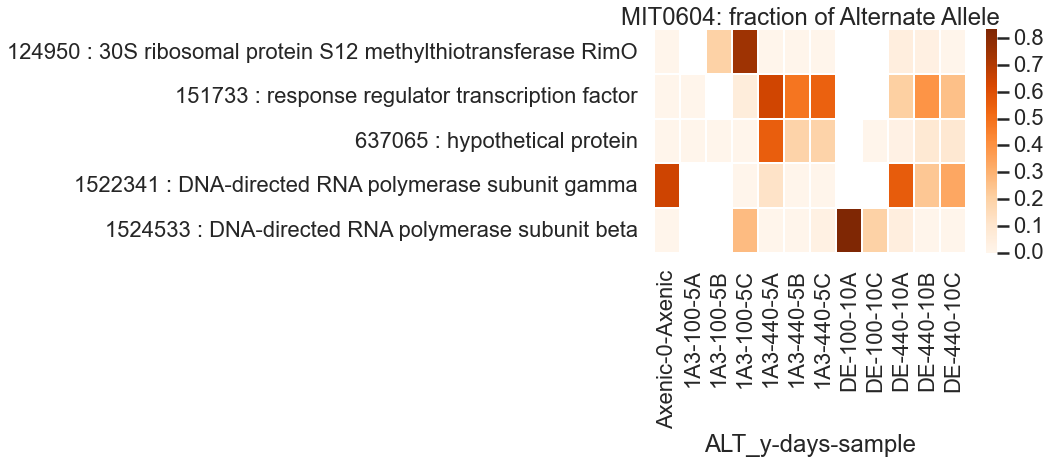

In [63]:
species = 'MIT0604'
plt.figure(figsize=(7,4))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)
               ].pivot_table(index=[ 'POS', 'product',], 
                                                columns=[ 'ALT_y', 'days','sample',], values='fraction_Alt', aggfunc='first')
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

Text(0.5, 1.0, 'MIT0604: fraction of Alternate Allele')

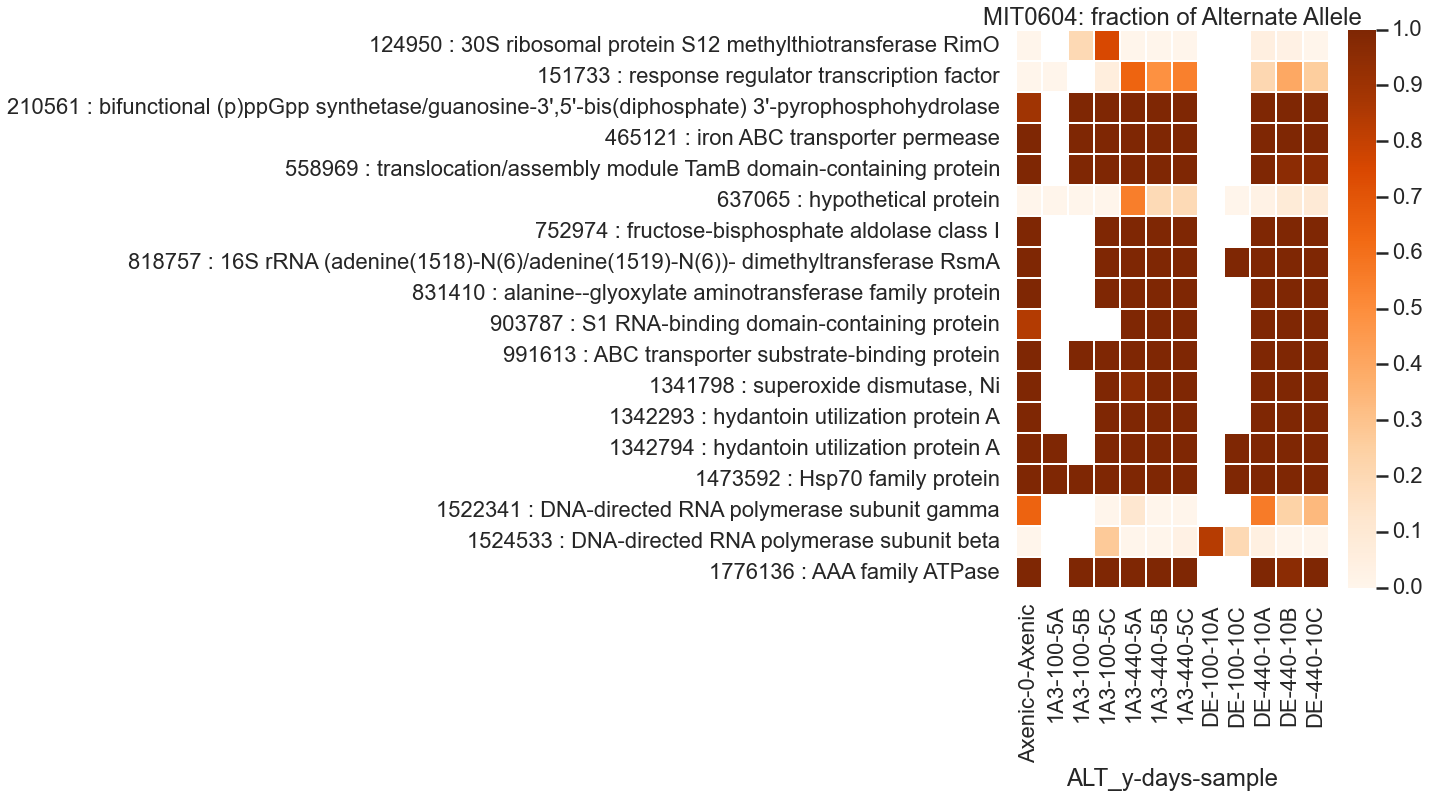

In [64]:
species = 'MIT0604'
plt.figure(figsize=(7,10))
pvdf = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species)
               ].pivot_table(index=[ 'POS', 'product',], 
                             columns=[ 'ALT_y', 'days','sample',], 
                             values='fraction_Alt', aggfunc='first', #dropna=False
                            )
pvdf = pvdf.reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',)
pvdf.index = [f'{col[0]} : {col[1]}' for col in pvdf.index.values]
sns.heatmap(pvdf, #.loc[pvdf.std(axis=1) > 1e-1], #.sort_values((  0, 'Axenic')),
            cmap='Oranges',
            linewidths=1, linecolor='white', #cbar=False
           )
plt.title(f'{species}: fraction of Alternate Allele')

In [65]:
pvdf.shape

(18, 12)

In [66]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species) &
                        #(dfs[species].call == 1) &
                        (dfs[species].days != 100)

 ].pivot_table(index=[ 'Impact','Annotation'], 
                              columns=['sample',], 
                              values='call', aggfunc='sum', margins=True, #dropna=False
                             )
#pivot_table(['sample',  'Impact','Annotation', ])['TYPE'].count().reset_index()

sample                       2A  2C  Axenic  All
Impact   Annotation                             
HIGH     frameshift_variant   8   8      10   26
         stop_gained          1   1       2    4
         stop_lost            1   1       1    3
LOW      synonymous_variant   6   5       8   19
MODERATE missense_variant    35  40      36  111
All                          51  55      57  163

In [67]:
species = 'MIT9313'
mdf = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species) &
                        #(dfs[species].call == 1) &
                        (dfs[species].days != 100)
               ].pivot_table(index=[ 'POS', 'Impact','Annotation'], 
                             columns=[ 'sample',], 
                             values='call', aggfunc='first', #dropna=False
                            ).reset_index()
mdf.head()

# ].pivot_table(index=[ 'Impact','Annotation'], 
#                              columns=['sample',], 
#                              values='fraction_Alt', aggfunc='count', #dropna=False
#                             )
#pivot_table(['sample',  'Impact','Annotation', ])['TYPE'].count().reset_index()

sample     POS    Impact          Annotation  2A  2C  Axenic
0        66297      HIGH  frameshift_variant   1   1       1
1        99578      HIGH         stop_gained   1   1       1
2       115483  MODERATE    missense_variant   0   0       1
3       148055  MODERATE    missense_variant   1   1       0
4       201575  MODERATE    missense_variant   1   1       0

In [68]:
    display(
        mdf.pivot_table(index=[ 'Axenic', '2A', '2C'], 
                             columns=[ 'Impact','Annotation',], 
                             values='POS', aggfunc='count',
                        margins=True, #dropna=False
                            ).reset_index().fillna(0)
    )


Impact     Axenic 2A 2C               HIGH                        \
Annotation              frameshift_variant stop_gained stop_lost   
0                     1                  0           0         0   
1                  1                     0           0         0   
2                  1  1                  0           0         0   
3               1                        2           1         0   
4               1  1                     0           0         0   
5               1  1  1                  8           1         1   
6             All                       10           2         1   

Impact                    LOW         MODERATE All  
Annotation synonymous_variant missense_variant      
0                           0                6   6  
1                           0                1   1  
2                           1               11  12  
3                           3               13  19  
4                           1                1   2  
5                           4               22  36  
6                           9               54  76

In [69]:
for s in ['2A', '2C']:
    display(
        mdf.pivot_table(index=[ 'Axenic', s], 
                             columns=[ 'Impact','Annotation',], 
                             values='POS', aggfunc='count',
                        margins=True, #dropna=False
                            ).reset_index().fillna(0)
    )


Impact     Axenic 2A               HIGH                        \
Annotation           frameshift_variant stop_gained stop_lost   
0                                     0           0         0   
1                  1                  0           0         0   
2               1                     2           1         0   
3               1  1                  8           1         1   
4             All                    10           2         1   

Impact                    LOW         MODERATE All  
Annotation synonymous_variant missense_variant      
0                           0                6   6  
1                           1               12  13  
2                           3               13  19  
3                           5               23  38  
4                           9               54  76

Impact     Axenic 2C               HIGH                        \
Annotation           frameshift_variant stop_gained stop_lost   
0                                     0           0         0   
1                  1                  0           0         0   
2               1                     2           1         0   
3               1  1                  8           1         1   
4             All                    10           2         1   

Impact                    LOW         MODERATE All  
Annotation synonymous_variant missense_variant      
0                           0                1   1  
1                           1               17  18  
2                           4               14  21  
3                           4               22  36  
4                           9               54  76

In [70]:
mdf.groupby(['Axenic', '2A', '2C']).count().reset_index()

sample  Axenic  2A  2C  POS  Impact  Annotation
0            0   0   1    6       6           6
1            0   1   0    1       1           1
2            0   1   1   12      12          12
3            1   0   0   19      19          19
4            1   1   0    2       2           2
5            1   1   1   36      36          36

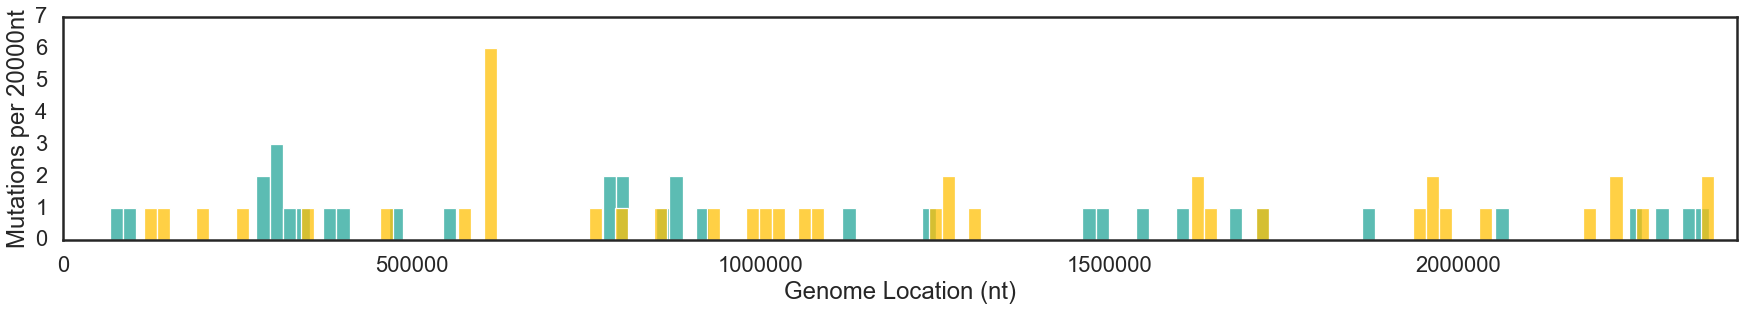

In [71]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp'])['call'].first().reset_index()
t1= t.loc[~t.diff_snp]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,4))


sns.histplot(t1['POS'], kde=False, bins=120, #hist_kws=dict(alpha=0.3), #rug=True,
             color='#26A69A', label='unchanged mutations')
sns.histplot(t2['POS'], kde=False, bins=120, #hist_kws=dict(alpha=0.5), #rug=True,
             color='#FFC107', #rug_kws=dict(height=1/3), 
             label='New Mutations')

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
#sns.scatterplot(x=t2.POS, y=7/3, s=400, color='#FFA000', alpha=0.25,#hue=t2.Annotation, 
                #markeredgecolor ='r',#palette='range', hue=1
                #markerfacecolors='none'
#               )
glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],10, glicine_region[1],10, marker='o',color='green' )
plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.ylabel('Mutations per 20000nt')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


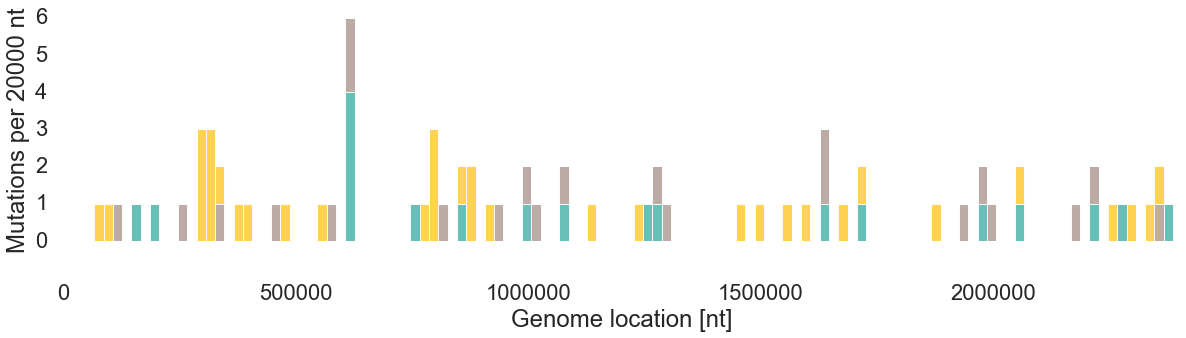

(0.0, 2400000.0)

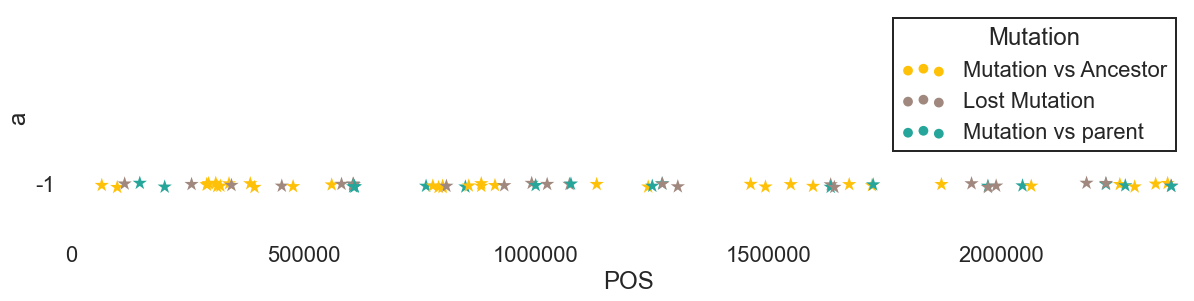

In [72]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp', 'days'])['call'].first().reset_index()
t = t.loc[t.days == 0]

t.loc[~t.diff_snp, 'Mutation'] = 'Mutation vs Ancestor'
t.loc[t.diff_snp & (t.call == 0), 'Mutation'] = 'Mutation vs parent'
t.loc[t.diff_snp & (t.call == 1), 'Mutation'] = 'Lost Mutation'
t['a'] = '-1'
plt.figure(figsize=(20,4))
ax = sns.histplot(data=t,  hue='Mutation', x='POS',binwidth=20000, #aspect=3, #kind='strip',
            #height=3, 
                multiple='stack',
                 # element='step',
            #order=['New Mutation','Removed Mutation', 'Existing Mutation',], 
            palette=[ '#FFC107', '#A1887F', '#26A69A',],
            #s=200, marker="*", 
            #edgecolor="gray", #
                  legend=False,
                 alpha=.7
           )
sns.despine(left=True, bottom=True)
plt.xlim(0,2.4e6)
plt.xlabel('Genome location [nt]')
plt.ylabel('Mutations per 20000 nt')

ax.tick_params(axis='x', pad=30)
plt.show()
plt.figure(figsize=(20,4))
sns.stripplot(data=t, y='a', hue='Mutation', x='POS', #aspect=5, #kind='strip',
            #height=3, 
            #order=['New Mutation','Removed Mutation', 'Existing Mutation',], 
            palette=[ '#FFC107', '#A1887F', '#26A69A',],
            s=15, marker="*", 
         #   ax =ax,
            #edgecolor="gray", #alpha=.5
           )
sns.despine(left=True, bottom=True)
#
plt.ylim(-2, 8)
#plt.ytics((0,1,2,3,4,5,6,7))
plt.xlim(0,2.4e6)

In [73]:
import urllib.parse
import urllib.request
import io

import requests, sys
# go terms for all mit9313 genes
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : 'taxonomy:74547',
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
mit9313_go_df1 = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [74]:
mit9313_go_df1.shape

(2834, 9)

In [75]:
mmit9313_go_df1 = mit9313_go_df1.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [76]:
s = mmit9313_go_df1['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df3 = mmit9313_go_df1.loc[i].copy()
df3["GO term"] = s.values
df3[["GO term", 'GOid']] = df3["GO term"].str.split(r' \[G', expand=True)
df3['GOid'] = df3['GOid'].str.replace(']', '')
df3['GOid'] = df3['GOid'].str.replace('O:', 'GO:')

C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


In [77]:
all_go_df = df3

In [78]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1


In [79]:
dfs[species].POS.value_counts()
#dfs[species].head().T
#dfs[species].columns
dfs[species].loc[dfs[species].POS==685346     ]

CHROM     POS TYPE REF ALT_x  species Allele          Annotation  \
510  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
511  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
512  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
513  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
514  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
515  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
516  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
517  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
518  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
519  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
520  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
521  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
522  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
523  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
524  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
525  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
526  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
527  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
528  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
529  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
530  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
531  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
532  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
533  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
534  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
535  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
536  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
537  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
538  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
539  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
540  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
541  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
542  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
543  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
544  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   
545  NC_005071  685346  SNP   N     G  MIT9313      G  intragenic_variant   

       Impact      Gene_Name  ...   days  ng/ul final volume call      PMTID1  \
510  MODIFIER  AKG35_RS00225  ...      0      1          100    1  PMT_RNA_44   
511  MODIFIER  AKG35_RS00225  ...    100      1          100  NaN  PMT_RNA_44   
512  MODIFIER  AKG35_RS00225  ...    440      1          100    1  PMT_RNA_44   
513  MODIFIER  AKG35_RS00225  ...    100      2          100    1  PMT_RNA_44   
514  MODIFIER  AKG35_RS00225  ...  empty  empty        empty  NaN  PMT_RNA_44   
515  MODIFIER  AKG35_RS00225  ...    440      8          100    1  PMT_RNA_44   
516  MODIFIER  AKG35_RS00225  ...      0      1          100    1  PMT_RNA_44   
517  MODIFIER  AKG35_RS00225  ...    100      1          100  NaN  PMT_RNA_44   
518  MODIFIER  AKG35_RS00225  ...    440      1          100    1  PMT_RNA_44   
519  MODIFIER  AKG35_RS00225  ...    100      2          100    1  PMT_RNA_44   
520  MODIFIER  AKG35_RS00225  ...  empty  empty        empty  NaN  PMT_RNA_44   
521  MODIFIER  AKG35_RS00225  ...    440      8          100    1  PMT_RNA_44   
522  MODIFIER  AKG35_RS00225  ...      0      1          100    1  PMT_RNA_44   
523  MODIFIER  AKG35_RS00

C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distr

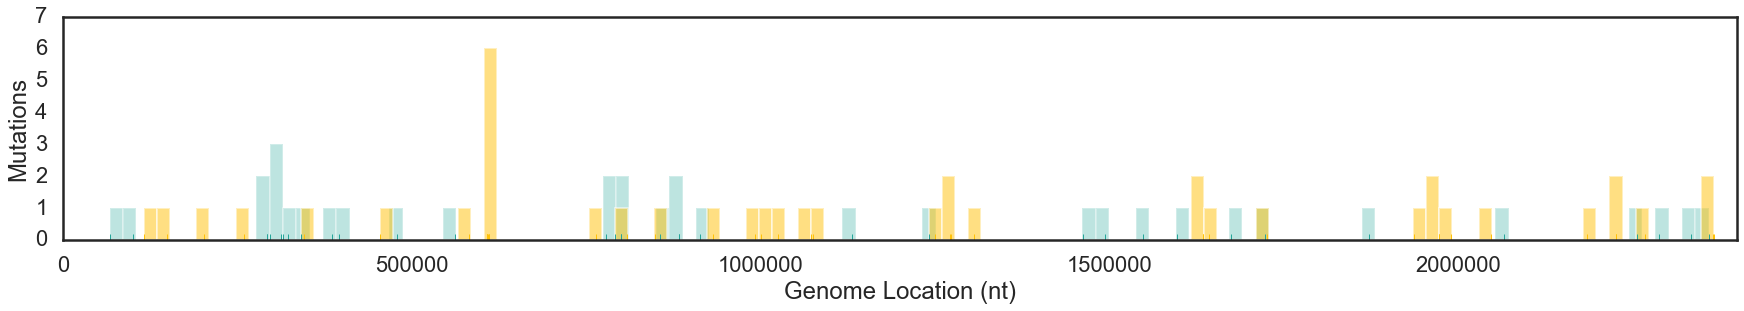

In [80]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp'])['call'].first().reset_index()
t1= t.loc[~t.diff_snp]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,4))


sns.distplot(t1['POS'], kde=False, bins=120, hist_kws=dict(alpha=0.3), rug=True, color='#26A69A', label='unchanged mutations')
sns.distplot(t2['POS'], kde=False, bins=120, hist_kws=dict(alpha=0.5), rug=True,
             color='#FFC107', #rug_kws=dict(height=1/3), 
             label='New Mutations')

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
#sns.scatterplot(x=t2.POS, y=7/3, s=400, color='#FFA000', alpha=0.25,#hue=t2.Annotation, 
                #markeredgecolor ='r',#palette='range', hue=1
                #markerfacecolors='none'
#               )
glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],10, glicine_region[1],10, marker='o',color='green' )
plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.ylabel('Mutations')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\seaborn\distr

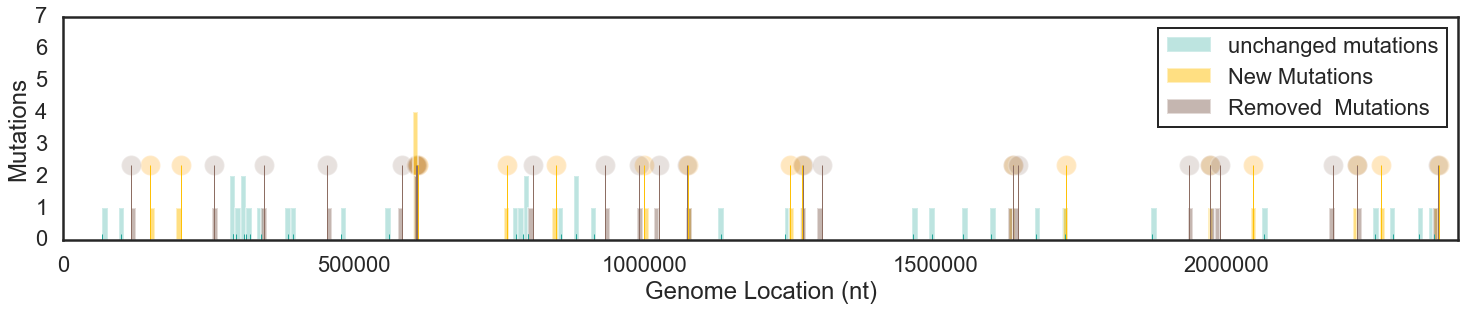

In [81]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp', 'days'])['call'].first().reset_index()
t = t.loc[t.days == 0]

t1= t.loc[~t.diff_snp]
t2= t.loc[t.diff_snp & (t.call == 0)]
t3= t.loc[t.diff_snp & (t.call == 1)]
plt.figure(figsize=(25,4))


sns.distplot(t1['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3), rug=True, color='#26A69A', label='unchanged mutations')
sns.distplot(t2['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.5), rug=True,
             color='#FFC107', rug_kws=dict(height=1/3), label='New Mutations')
sns.distplot(t3['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.5), rug=True,
             color='#8D6E63', rug_kws=dict(height=1/3), label='Removed  Mutations')

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
sns.scatterplot(x=t2.POS, y=7/3, s=400, color='#FFA000', alpha=0.25)
sns.scatterplot(x=t3.POS, y=7/3, s=400, color='#A1887F', alpha=0.25)

glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],10, glicine_region[1],10, marker='o',color='green' )
plt.ylim(0,7)
plt.xlabel('Genome Location (nt)')
plt.ylabel('Mutations')
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


(0.0, 2400000.0)

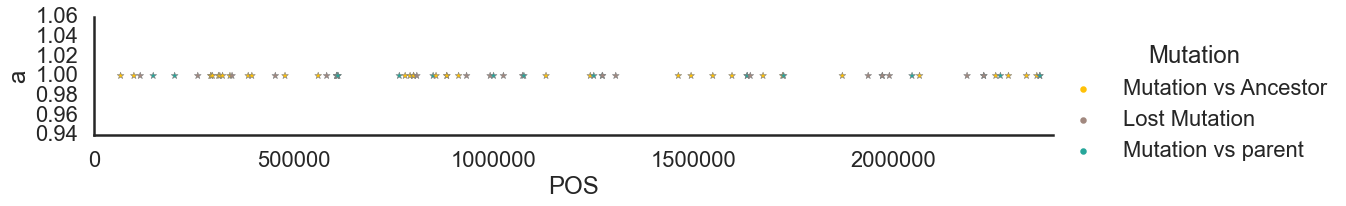

In [82]:
species = 'MIT9313'
t = dfs[species]
t = t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp', 'days'])['call'].first().reset_index()
t = t.loc[t.days == 0]

t.loc[~t.diff_snp, 'Mutation'] = 'Mutation vs Ancestor'
t.loc[t.diff_snp & (t.call == 0), 'Mutation'] = 'Mutation vs parent'
t.loc[t.diff_snp & (t.call == 1), 'Mutation'] = 'Lost Mutation'
t['a'] = 1
sns.relplot(data=t, y='a', hue='Mutation', x='POS', aspect=5, #kind='strip',
            height=3, 
            #order=['New Mutation','Removed Mutation', 'Existing Mutation',], 
            palette=[ '#FFC107', '#A1887F', '#26A69A',],
            s=50, marker="*", 
            edgecolor="gray", #alpha=.5
           )
plt.xlim(0,2.4e6)

In [83]:
df_genome.type.value_counts()

CDS           2403
tRNA            44
rRNA             6
ncRNA            3
regulatory       2
tmRNA            1
Name: type, dtype: int64

In [84]:
species = 'MIT9313'
t = dfs[species]
t.loc[t.type.isin(['CDS'])].groupby(['POS', 'TYPE', 'diff_snp'])['call'].first().reset_index().diff_snp.value_counts()


True     41
False    35
Name: diff_snp, dtype: int64

In [85]:
number_of_mit9313_cds = 2403
number_of_read_mutations = 41
from scipy.stats import binom 
n = number_of_mit9313_cds
r = number_of_read_mutations
p = 1-1/n
#res = [binom.pmf(k=r, n=n, p=p) for r in range(50)]
#sns.lineplot(x=range(50), y=res)
1 - np.exp(-r*(r-1)/(2*n)) , 1 - ((n - 1)/n)**r

(0.2891118082881201, 0.016920765161884233)

Text(0, 0.5, 'probability of 2 mutations on the same gene')

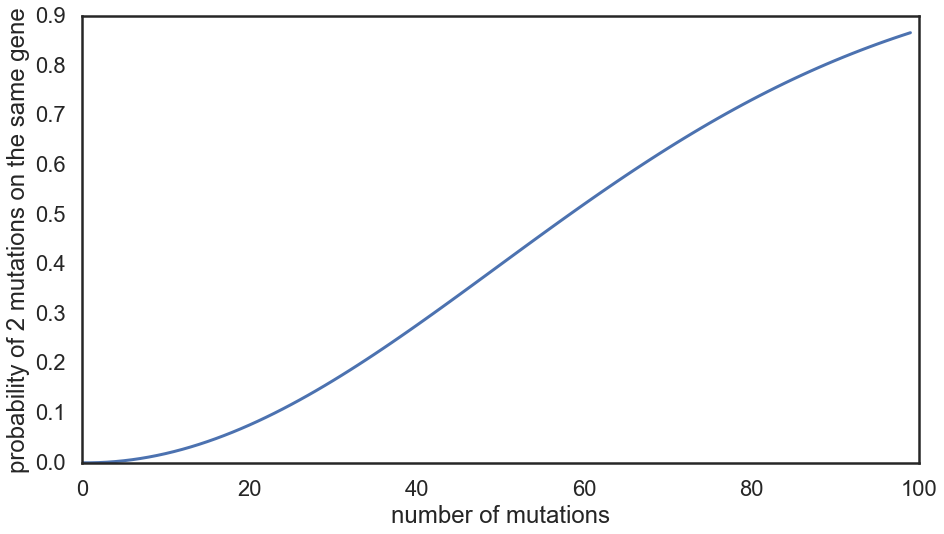

In [86]:
number_of_mit9313_cds = 2403
number_of_read_mutations = 41
from scipy.stats import binom 
n = number_of_mit9313_cds
r = number_of_read_mutations
p = 1-1/n
res = [1 - np.exp(-r*(r-1)/(2*n)) for r in range(100)]
sns.lineplot(x=range(100), y=res)
#1 - np.exp(-r*(r-1)/(2*n)) , np.sqrt(2*n*np.log(1/(1-1/n)))
plt.xlabel('number of mutations')
plt.ylabel('probability of 2 mutations on the same gene')

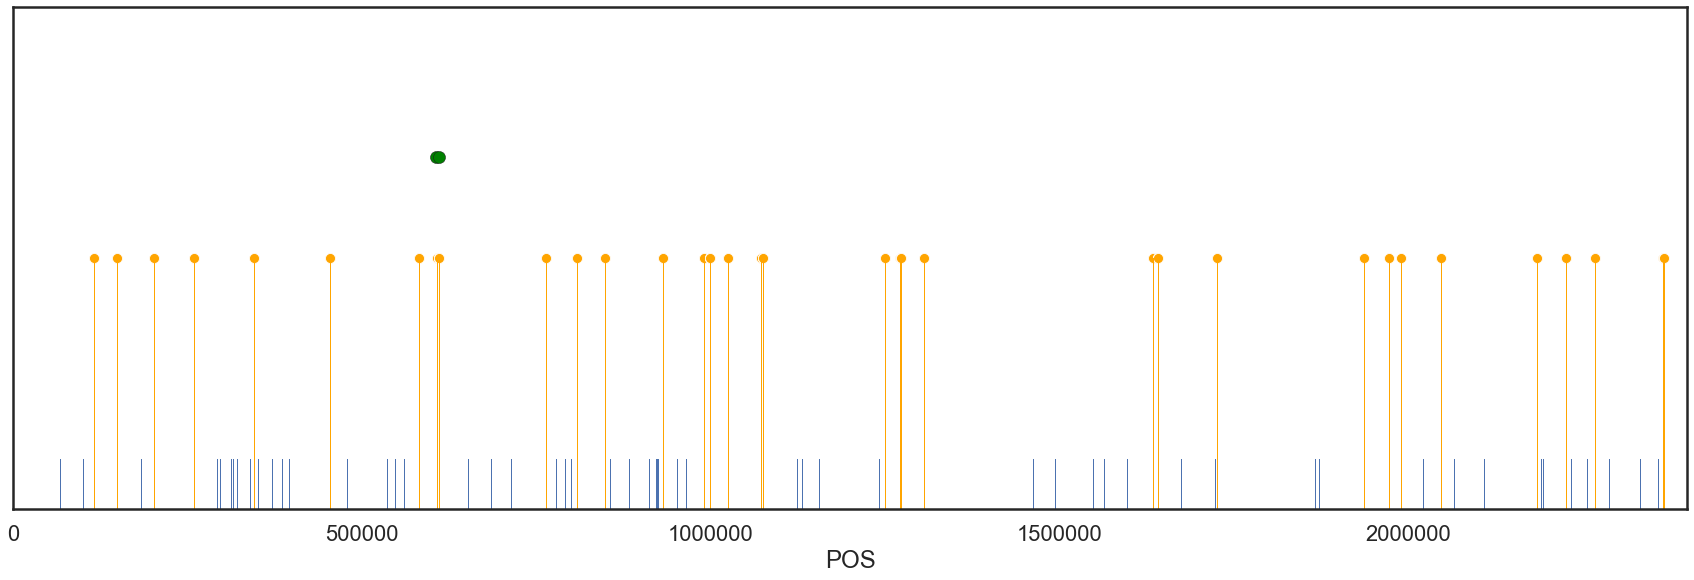

In [87]:
species = 'MIT9313'
t = dfs[species]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,9))

#sns.distplot(t['POS'], kde=False, bins=240, hist_kws=dict(alpha=0.3))

sns.rugplot(t.POS, height=0.1)
sns.rugplot(t2.POS, height=0.5, color='Orange')
sns.scatterplot(x=t2.POS, y=0.5, s=100, #hue=t2.Annotation, 
                color='orange'#palette='range', hue=1
               )
glicine_region = (605826, 610831)
plt.plot(glicine_region[0],0.7, glicine_region[1],0.7, marker='o',color='green' 
        )
plt.ylim(0,1)
plt.xlim(0,2.4e6)
plt.yticks([])
plt.show()


In [88]:
2.4e6/240


10000.0

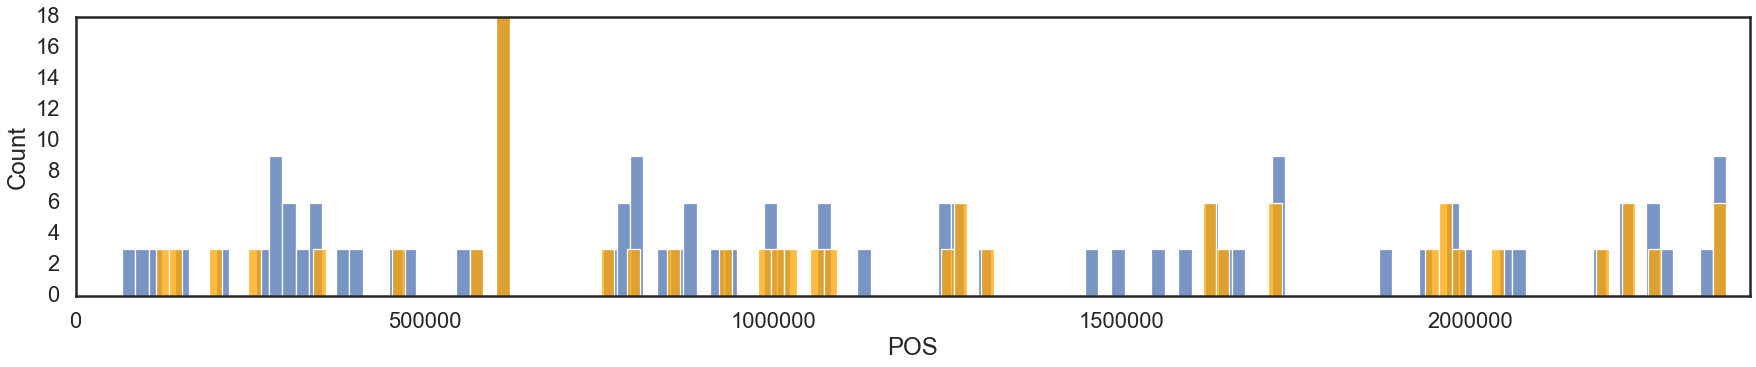

In [89]:
species = 'MIT9313'
t = dfs[species].loc[(dfs[species].type == 'CDS') & 
                         dfs[species].good_call & 
                        (dfs[species].PRO == species) &
                        #(dfs[species].call == 1) &
                        (dfs[species].days != 100)]
t2= t.loc[t.diff_snp]
plt.figure(figsize=(30,5))

sns.histplot(t['POS'], kde=False, bins=120, #hist_kws=dict(alpha=0.3), 
            #rug=False
            )
sns.histplot(t2['POS'], kde=False, bins=120, #hist_kws=dict(alpha=0.3), 
             #rug=False, 
             color='orange', #rug_kws=dict(height=0.5)
            )

#sns.rugplot(t.POS, height=0.1)
#sns.rugplot(t2.POS, height=0.5, color='Orange')
#sns.scatterplot(x=t2.POS, y=60, s=200, color='Orange', #hue=t2.Annotation, 
#                #markeredgecolor ='r',#palette='range', hue=1
#                #markerfacecolors='none'
#               )
glicine_region = (605826, 610831)
#plt.plot(glicine_region[0],0.7, glicine_region[1],0.7, marker='o',color='green' 
#        )
#plt.ylim(0,1)
plt.xlim(0,2.4e6)
#plt.yticks([])
plt.show()


In [90]:
t2.Annotation

36        missense_variant
38        missense_variant
41        missense_variant
48        missense_variant
50        missense_variant
               ...        
1484    frameshift_variant
1487    frameshift_variant
1488      missense_variant
1490      missense_variant
1493      missense_variant
Name: Annotation, Length: 126, dtype: object

In [91]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1


In [92]:
pvdf.head()

days   protein_id        gene_id  \
sample                             
0                  AKG35_RS00340   
1                  AKG35_RS01460   
2                  AKG35_RS01490   
3                  AKG35_RS01575   
4                  AKG35_RS03750   

days                                              product      0 100     440  \
sample                                                    Axenic  2A  2C  2A   
0                    aspartate-semialdehyde dehydrogenase      1 NaN NaN   1   
1       bifunctional demethylmenaquinone methyltransfe...      1 NaN   1   1   
2                           VTT domain-containing protein      1 NaN   1   1   
3                           thermonuclease family protein      1 NaN NaN   1   
4                                  DUF1995 family protein      1 NaN NaN   1   

days      actual_snp  
sample 2C             
0       1      False  
1       1      False  
2       1      False  
3       1      False  
4       1      False

In [93]:
protein_ids = pvdf.loc[~pvdf.protein_id.isin(['']), #& pvdf.actual_snp,
                       'protein_id'].unique()


In [94]:
len(protein_ids)

60

In [95]:
pstr = ' '.join([p for p in protein_ids.tolist() if p != ''])

In [96]:
pstr

'WP_011129469.1 WP_011129480.1 WP_011129508.1 WP_011129556.1 WP_011129603.1 WP_011129635.1 WP_011129636.1 WP_011129650.1 WP_011129680.1 WP_011129717.1 WP_011129725.1 WP_011129782.1 WP_011129804.1 WP_011129889.1 WP_011129912.1 WP_011129931.1 WP_011130106.1 WP_011130118.1 WP_011130153.1 WP_011130158.1 WP_011130182.1 WP_011130230.1 WP_011130287.1 WP_011130318.1 WP_011130365.1 WP_011130370.1 WP_011130529.1 WP_011130551.1 WP_011130587.1 WP_011130745.1 WP_011130775.1 WP_011130875.1 WP_011130908.1 WP_011130909.1 WP_011130942.1 WP_011130986.1 WP_011130990.1 WP_011130991.1 WP_011131144.1 WP_011131194.1 WP_011131250.1 WP_011131302.1 WP_011131319.1 WP_011131475.1 WP_011131506.1 WP_011131514.1 WP_011131527.1 WP_011131595.1 WP_011131603.1 WP_041375225.1 WP_041384309.1 WP_041384560.1 WP_041384967.1 WP_041385020.1 WP_041385260.1 WP_157859810.1 WP_157859846.1 WP_157859934.1 WP_157859940.1 WP_157859964.1'

In [97]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'P_REFSEQ_AC',
'to': 'ACC',
'format': 'tab',
'query': pstr
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
pid2unip_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [98]:
import urllib.parse
import urllib.request
import io

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'UPARC',
'to': 'ACC',
'format': 'tab',
'query': '\n'.join(pid2unip_df.To.unique().tolist())
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
acc2id_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [99]:
acc2id_df.index = acc2id_df.From
pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'] = \
    pid2unip_df.loc[pid2unip_df.To.isin(acc2id_df.From), 'To'].map(acc2id_df.To)


In [100]:
pid2unip_df.shape

(73, 2)

In [101]:
unip_lst = 'accession:' + ' OR accession:'.join(pid2unip_df.To.unique().tolist())
unip_lst

'accession:Q7V968 OR accession:Q7V957 OR accession:Q7V933 OR accession:Q7V8Z3 OR accession:A0A163EME4 OR accession:A0A163S2P6 OR accession:A0A163VMQ3 OR accession:Q7V8V1 OR accession:Q7V8S5 OR accession:Q7V8S4 OR accession:Q7V8R1 OR accession:Q7V8N6 OR accession:A0A162E0T5 OR accession:Q7V8K6 OR accession:Q7V8J9 OR accession:Q7V8F0 OR accession:Q7V8D1 OR accession:Q7V861 OR accession:Q7V840 OR accession:Q7V822 OR accession:Q7TV00 OR accession:Q7TUZ8 OR accession:A0A0A2CGP8 OR accession:A0A162DVP7 OR accession:A0A163D3F3 OR accession:A0A163D7F0 OR accession:A0A163Q2W7 OR accession:A0A163UPZ6 OR accession:Q7V7H1 OR accession:Q7V7G6 OR accession:Q7V7E4 OR accession:Q7V7A2 OR accession:Q7V749 OR accession:Q7V721 OR accession:Q7V6Y4 OR accession:Q7V6Y2 OR accession:Q7V6K1 OR accession:Q7V6H9 OR accession:Q7V6E7 OR accession:Q7V606 OR accession:Q7V5X8 OR accession:Q7V5P1 OR accession:A0A162EP96 OR accession:A0A163UZE4 OR accession:Q7V5L2 OR accession:A0A163RB06 OR accession:Q7V5L1 OR accessi

In [102]:
url = 'https://www.uniprot.org/uniprot/'
columns =  ['id','entry name','protein names','genes','organism','length',
            'go(biological process)','go(cellular component)',
    'go(molecular function)']

params = {
    'query' : unip_lst,
    'format' : 'tab',
    'columns' : ','.join(columns),
    'compress' : 'no',
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()
uni2go_df = pd.read_csv(io.StringIO(response.decode('utf-8')), sep='\t')



In [103]:
uni2go_df.shape

(64, 9)

In [104]:
uni2go_df = uni2go_df.loc[uni2go_df['Organism'].isin(['Prochlorococcus marinus (strain MIT 9313)'])]

uni2go_df.columns

Index(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism',
       'Length', 'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)'],
      dtype='object')

In [105]:
uni2go_df.shape

(50, 9)

In [106]:
uni_df = pd.merge(pid2unip_df, uni2go_df, left_on='To', right_on='Entry', how='right')
uni_df = pd.merge(pvdf.droplevel(axis=1, level=1).loc[pvdf.actual_snp], uni_df, left_on='protein_id', right_on='From', how='left')

In [107]:
uni_df.shape

(35, 20)

In [108]:
uni_df.head()

protein_id        gene_id                                  product  0  \
0  WP_011129480.1  AKG35_RS12145          GNAT family N-acetyltransferase  1   
1  WP_011129508.1  AKG35_RS00645  efflux RND transporter permease subunit  0   
2  WP_011129556.1  AKG35_RS00885                      L-aspartate oxidase  0   
3  WP_011129603.1  AKG35_RS01190                      cysteine synthase A  1   
4  WP_011129680.1  AKG35_RS01605                     hypothetical protein  1   

   100  100  440  440  actual_snp            From      To   Entry  \
0  NaN    1    0    0        True  WP_011129480.1  Q7V957  Q7V957   
1  NaN    0    1    1        True  WP_011129508.1  Q7V933  Q7V933   
2  NaN    0    1    1        True  WP_011129556.1  Q7V8Z3  Q7V8Z3   
3  NaN    1    0    0        True  WP_011129603.1  Q7V8V1  Q7V8V1   
4    1  NaN    0    0        True  WP_011129680.1  Q7V8N6  Q7V8N6   

     Entry name                                     Protein names  \
0  Q7V957_PROMM                                 Acetyltransferase   
1  Q7V933_PROMM  Putative RND family multidrug efflux transporter   
2  Q7V8Z3_PROMM                 L-aspartate oxidase (EC 1.4.3.16)   
3  Q7V8V1_PROMM                   Cysteine synthase (EC 2.5.1.47)   
4  Q7V8N6_PROMM          Possible Fanconi anaemia group C protein   

       Gene names                                   Organism  Length  \
0        PMT_0101  Prochlorococcus marinus (strain MIT 9313)     179   
1        PMT_0129  Prochlorococcus marinus (strain MIT 9313)    1086   
2   nadB PMT_0177  Prochlorococcus marinus (strain MIT 9313)     556   
3  cysK1 PMT_0224  Prochlorococcus marinus (strain MIT 9313)     328   
4        PMT_0301  Prochlorococcus marinus (strain MIT 9313)     214   

                  Gene ontology (biological process)  \
0                                                NaN   
1                                                NaN   
2              NAD biosynthetic process [GO:0009435]   
3  cysteine biosynthetic process from serine [GO:...   
4                                                NaN   

            Gene ontology (cellular component)  \
0                                          NaN   
1  integral component of membrane [GO:0016021]   
2                       cytoplasm [GO:0005737]   
3                                          NaN   
4                                          NaN   

                  Gene ontology (molecular function)  
0          N-acetyltransferase activity [GO:0008080]  
1    transmembrane transporter activity [GO:0022857]  
2  L-aspartate:fumarate oxidoreductase activity [...  
3  cysteine synthase activity [GO:0004124]; lyase...  
4                                                NaN

In [109]:
uni_df.columns

Index([                        'protein_id',
                                  'gene_id',
                                  'product',
                                          0,
                                        100,
                                        100,
                                        440,
                                        440,
                               'actual_snp',
                                     'From',
                                       'To',
                                    'Entry',
                               'Entry name',
                            'Protein names',
                               'Gene names',
                                 'Organism',
                                   'Length',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)'],
      dtype='object')

In [110]:
dfs[species].loc[dfs[species].type.isin(['CDS'])].diff_snp.value_counts()

True     252
False    210
Name: diff_snp, dtype: int64

In [111]:
all_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'RO', 'fraction_Alt', 'culture', 'gene_id', 'pmt_id',
       'type', 'strand', 'product', 'pmt_id', 'PMTID2', 'Synonym', 'q Value ',
       'log Fold Change', 'sample', 'PRO', 'ALT_y', 'exp',
       'days', 'ng/ul', 'final volume']
 

uni_cols = [                   
                                  'gene_id',
                               'Entry name',
                            'Protein names',
                               'Gene names',
                                 'Organism',
                                   'Length',
       'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)',
]

    
index_cols = ['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'Annotation', 'Impact',
              'HGVS.p', 'HGVS.c', 'CDS.pos', 'AA.pos',
              'gene_id', 
                                             'Entry name',
                               'Gene names','pmt_id',
                            'Protein names','product',
              'diff_snp',
#                                 'Organism',
                                   'Length',
#       'Gene ontology (biological process)',
#       'Gene ontology (cellular component)',
#       'Gene ontology (molecular function)',
     #'type', 
              'strand', ]
additional_index_cols = ['q Value ', 'log Fold Change',]

column_cols = ['PRO', 'ALT_y', 'days','sample', ]
value_cols = ['call', 'fraction_Alt', #'DP', 'AO', 'RO','GQ','GT',  
             ]
species= 'MIT9313'

toprint_df = pd.merge(dfs[species].loc[dfs[species]['type'].isin(['CDS']) 
                                       #& dfs[species]['gene_id'].isin(uni_df['gene_id'])
                                      ],
                      uni_df[uni_cols], 
                      on='gene_id', how='left', suffixes=('', '_y'),)

condition_format_cols = {
    'MIT9313' : ['X7:AB10000', 'AC7:AG10000' ],
    'MIT0604' : ['R7:AD10000', 'AE7:AQ10000' ],
    '1A3' : ['R7:AB10000', 'AC7:AM10000' ],
    'DE' : ['R7:X20000', 'Y7:AE10000' ],
    
}  
fraction_cols = {
    'MIT9313' :  'AC:AG',
    'MIT0604' :  'AE:AQ',
    '1A3' : 'AC:AM' ,
    'DE' :  'Y:AE' ,
    
}  


#agg_f = lambda x : ' | '.join(x.unique())
with pd.ExcelWriter('var_calls_5x5_MIT9313_uniprot.xlsx', engine='xlsxwriter') as writer:  
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00'})
    format2 = workbook.add_format({'num_format': '0%'})
    # Light red fill with dark red text.
    format_red = workbook.add_format({'bg_color':   '#FFC7CE',
                                   'font_color': '#9C0006'})

    # Light yellow fill with dark yellow text.
    format_yellow = workbook.add_format({'bg_color':   '#FFEB9C',
                                   'font_color': '#9C6500'})

    # Green fill with dark green text.
    format_green = workbook.add_format({'bg_color':   '#C6EFCE',
                                   'font_color': '#006100'})
    #for species, col in zip(['MIT9313', 'MIT0604', '1A3', 'DE'], ['PRO', 'PRO', 'ALT_y', 'ALT_y']):
    for species, col in zip(['MIT9313'], ['PRO']):
        actual_index_cols = index_cols
        if species == 'MIT9313':
            actual_index_cols = index_cols + additional_index_cols
        excel_pdf = toprint_df.fillna('').pivot_table(
            index=actual_index_cols, columns=column_cols,
            aggfunc='first', margins=False, values=value_cols,
            fill_value='',
        ).reindex(columns=value_cols, level=0,
        ).reindex(columns=['Axenic', '1A3', 'DE'], level='ALT_y',
        ).reindex(columns=['Axenic', 'MIT9313', 'MIT0604'], level='PRO',).reset_index()
        #excel_pdf = excel_pdf.loc[excel_pdf['call'].replace('',np.NaN).std(axis=1) != 0]
        sheetname = f'{species} calls'
        excel_pdf.to_excel(writer, sheet_name=sheetname)
        worksheet = writer.sheets[sheetname]
        worksheet.set_column(fraction_cols[species], None, format1)
        if species == 'MIT9313':
            worksheet.set_column('U:V', None, format1)
        worksheet.set_column('Q:R', 30)  # Col 1 has format1.
        worksheet.set_column('G:G', 12)  # Col 1 has format1.
                
        worksheet.conditional_format(condition_format_cols[species][0], 
                                     {'type': '2_color_scale',                               
                                      'min_color': '#b7efcd', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#ffbcbc'
                                     })
        worksheet.conditional_format(condition_format_cols[species][1],  
                                     {'type': '2_color_scale',                               
                                      'min_color': 'white', 
                                    #  'mid_color': 'yellow', 
                                      'max_color': '#f69e7b'
                                     })
        worksheet.conditional_format('B7:S1000' ,
                                     {'type':     'formula',
                                      'criteria': '$S7="TRUE"',
                                      'format':   format_yellow
    })
        #worksheet.conditional_format(f'K1:L{bamqc_df.shape[0]+2}', {'type': 'data_bar', 'bar_color' : 'green'})


In [112]:
toprint_df.columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call', 'PMTID1', 'PMTID2', 'Synonym', 'q Value ', 'log Fold Change',
       'diff_snp', 'Entry name', 'Protein names', 'Gene names', 'Organism',
       'Length', 'Gene ontology (biological process)',
       'Gene ontology (cellular component)',
       'Gene ontology (molecular function)'],
      dtype='object')

In [113]:
toprint_df.diff_snp.value_counts()

True     252
False    210
Name: diff_snp, dtype: int64

In [114]:
dfs[species].loc[dfs[species]['type'].isin(['CDS'])].columns

Index(['CHROM', 'POS', 'TYPE', 'REF', 'ALT_x', 'species', 'Allele',
       'Annotation', 'Impact', 'Gene_Name', 'Gene_ID', 'Feature_Type',
       'Feature_ID', 'Transcript_BioType', 'Rank', 'HGVS.c', 'HGVS.p',
       'cDNA.pos', 'CDS.pos', 'AA.pos', 'Distance', 'ERRORS', 'sample_number',
       'AO', 'DP', 'GQ', 'GT', 'RO', 'good_call', 'fraction_Alt', 'culture',
       'gene_id', 'pmt_id', 'type', 'strand', 'product', 'protein_id',
       'sample', 'PRO', 'ALT_y', 'exp', 'days', 'ng/ul', 'final volume',
       'call', 'PMTID1', 'PMTID2', 'Synonym', 'q Value ', 'log Fold Change',
       'diff_snp'],
      dtype='object')

In [115]:
dfs[species].loc[dfs[species]['type'].isin(['CDS']) & dfs[species]['call'].isin([1])].dropna(subset=['call']).pivot_table(
    index=['sample'], columns=['diff_snp', 'days', ], values='POS', aggfunc='count')

diff_snp False         True         
days       0   100 440   0   100 440
sample                              
2A         NaN   2  35   NaN   2  16
2C         NaN  20  35   NaN  10  20
Axenic      35 NaN NaN    22 NaN NaN

In [116]:
dfs[species].loc[dfs[species]['type'].isin(['CDS']) & dfs[species]['call'].isin([0])].dropna(subset=['call']).pivot_table(
    index=['sample'], columns=['diff_snp', 'days', ], values='POS', aggfunc='count')

diff_snp True        
days      0   100 440
sample               
2A        NaN   1  26
2C        NaN  14  22
Axenic     20 NaN NaN

In [117]:
dfs[species].loc[dfs[species]['type'].isin(['CDS'])].dropna(subset=['call']).groupby('diff_snp').days.value_counts()

diff_snp  days
False     440     70
          0       35
          100     22
True      440     84
          0       42
          100     27
Name: days, dtype: int64

In [118]:
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['diff_snp','POS'], 
                                                columns=[  'sample','days',], values='call', aggfunc='first').reset_index()


In [119]:
pvdf.head()

sample diff_snp     POS  2A      2C     Axenic
days                    100 440 100 440      0
0         False   66297 NaN   1 NaN   1      1
1         False   99578 NaN   1   1   1      1
2         False  292217 NaN   1 NaN   1      1
3         False  292226 NaN   1   1   1      1
4         False  296103 NaN   1   1   1      1

In [120]:
pvdf.columns

MultiIndex([('diff_snp',  ''),
            (     'POS',  ''),
            (      '2A', 100),
            (      '2A', 440),
            (      '2C', 100),
            (      '2C', 440),
            (  'Axenic',   0)],
           names=['sample', 'days'])

In [121]:
pvdf.groupby(['diff_snp', (  'Axenic',   0)]).sum()

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sample                     POS  2A      2C    
days                           100 440 100 440
diff_snp (Axenic, 0)                          
False    1            35891371   2  35  20  35
True     0            23229458   0  13   1  18
         1            26323527   2   3   9   1

In [122]:
pvdf.groupby(['diff_snp', (  'Axenic',   0)]).count() - pvdf.groupby(['diff_snp', (  'Axenic',   0)]).sum()

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sample                     POS  2A      2C    
days                           100 440 100 440
diff_snp (Axenic, 0)                          
False    1           -35891336   0   0   0   0
True     0           -23229439   0   6  10   1
         1           -26323505   1  19   4  21

In [123]:
pvdf.groupby(['diff_snp', ]).count()

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sample   POS  2A      2C     Axenic
days         100 440 100 440      0
diff_snp                           
False     35   2  35  20  35     35
True      41   3  41  24  41     41

In [124]:
pvdf.groupby(['diff_snp', ]).sum()

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sample         POS  2A      2C     Axenic
days               100 440 100 440      0
diff_snp                                 
False     35891371   2  35  20  35     35
True      49552985   2  16  10  19     22

In [125]:
species = 'MIT9313'
pvdf = dfs[species].pivot_table(index=['POS'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
#pvdf = pvdf.reset_index()
pvdf.loc[pvdf.std(axis=1) > 1e-1].shape
good_call_pos = pvdf.loc[pvdf.std(axis=1) > 1e-1].index
good_call_pos
dfs[species]['diff_snp_all'] = False
dfs[species].loc[dfs[species]['POS'].isin(good_call_pos), 'diff_snp_all'] = True
#pvdf.shape


In [126]:
dfs[species]['diff_snp_all'].value_counts()


True     756
False    738
Name: diff_snp_all, dtype: int64

In [127]:
pvdf = dfs[species].pivot_table(index=['diff_snp_all','POS'], 
                                                columns=[  'sample','days',], values='call', aggfunc='first').reset_index()


In [128]:
pvdf.head()

sample diff_snp_all     POS  2A      2C     Axenic
days                        100 440 100 440      0
0             False   66297 NaN   1 NaN   1      1
1             False   99525 NaN   1 NaN   1      1
2             False   99578 NaN   1   1   1      1
3             False  292217 NaN   1 NaN   1      1
4             False  292226 NaN   1   1   1      1

In [129]:
pvdf.columns

MultiIndex([('diff_snp_all',  ''),
            (         'POS',  ''),
            (          '2A', 100),
            (          '2A', 440),
            (          '2C', 100),
            (          '2C', 440),
            (      'Axenic',   0)],
           names=['sample', 'days'])

In [130]:
pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).sum()

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sample                         POS  2A      2C    
days                               100 440 100 440
diff_snp_all (Axenic, 0)                          
False        1            54251290   2  49  27  49
True         0            29272335   0  18   1  24
             1            30353016   2   3  12   0

In [131]:
pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).count() - pvdf.groupby(['diff_snp_all', (  'Axenic',   0)]).sum()

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sample                         POS  2A      2C    
days                               100 440 100 440
diff_snp_all (Axenic, 0)                          
False        1           -54251241   0   0   0   0
True         0           -29272310   0   7  12   1
             1           -30352989   1  24   4  27

In [132]:
pvdf.groupby(['diff_snp_all', ]).count()

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sample       POS  2A      2C     Axenic
days             100 440 100 440      0
diff_snp_all                           
False         49   2  49  27  49     49
True          52   3  52  29  52     52

In [133]:
pvdf.groupby(['diff_snp_all', ]).sum()

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


sample             POS  2A      2C     Axenic
days                   100 440 100 440      0
diff_snp_all                                 
False         54251290   2  49  27  49     49
True          59625351   2  21  13  24     27

In [134]:
pvdf.sum()

sample        days
diff_snp_all                52
POS                  113876641
2A            100            4
              440           70
2C            100           40
              440           73
Axenic        0             76
dtype: float64

# go terms

In [135]:
mdf = uni2go_df.melt(
    id_vars=['Entry', 'Entry name', 'Protein names', 'Gene names', 'Organism', 'Length'],
    value_name='GO term',
    var_name='GO aspect',
).dropna(subset=['GO term'],axis=0).reset_index(drop=True)

In [136]:
mdf.head()

Entry  Entry name                                      Protein names  \
0  Q7V4J7  PSAC_PROMM  Photosystem I iron-sulfur center (EC 1.97.1.12...   
1  Q7TUZ8  RS18_PROMM                          30S ribosomal protein S18   
2  Q7V5P1  RPOB_PROMM  DNA-directed RNA polymerase subunit beta (RNAP...   
3  Q7V8S4  LEPA_PROMM  Elongation factor 4 (EF-4) (EC 3.6.5.n1) (Ribo...   
4  Q7V8F0  GLGA_PROMM  Glycogen synthase (EC 2.4.1.21) (Starch [bacte...   

            Gene names                                   Organism  Length  \
0        psaC PMT_1954  Prochlorococcus marinus (strain MIT 9313)      81   
1  rpsR rps18 PMT_0740  Prochlorococcus marinus (strain MIT 9313)      73   
2        rpoB PMT_1507  Prochlorococcus marinus (strain MIT 9313)    1097   
3        lepA PMT_0257  Prochlorococcus marinus (strain MIT 9313)     604   
4        glgA PMT_0403  Prochlorococcus marinus (strain MIT 9313)     499   

                            GO aspect  \
0  Gene ontology (biological process)   
1  Gene ontology (biological process)   
2  Gene ontology (biological process)   
3  Gene ontology (biological process)   
4  Gene ontology (biological process)   

                                             GO term  
0  photosynthetic electron transport in photosyst...  
1                           translation [GO:0006412]  
2          transcription, DNA-templated [GO:0006351]  
3                           translation [GO:0006412]  
4         glycogen biosynthetic process [GO:0005978]

In [137]:
s = mdf['GO term'].str.split('; ', expand=True).stack()
i = s.index.get_level_values(0)
df2 = mdf.loc[i].copy()
df2["GO term"] = s.values
df2[["GO term", 'GOid']] = df2["GO term"].str.split(r' \[', expand=True)
df2['GOid'] = df2['GOid'].str.replace(']', '')

C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


In [138]:
import requests, sys
import json
goterms = df2['GOid'].unique().tolist()
termsstr = ','.join(goterms)

requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{termsstr}/ancestors?relations=is_a%2Cpart_of%2Coccurs_in%2Cregulates"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
#print(responseBody)
json_rec = json.loads(responseBody)


In [139]:
ancestor_ids = {j for i in json_rec['results']for j in i['ancestors'] }

KeyError: 'ancestors'

In [ ]:
len(ancestor_ids)

In [ ]:
import requests, sys

ancestorsstr = ','.join(ancestor_ids)
requestURL = f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{ancestorsstr}"

r = requests.get(requestURL, headers={ "Accept" : "application/json"})

if not r.ok:
  r.raise_for_status()
  sys.exit()

responseBody = r.text
ancestor_json_rec = json.loads(responseBody)
ancestor_json_rec
ancestor_names = []
ancestor_names = {i['id'] : i['name'] for i in ancestor_json_rec['results'] }


In [ ]:
ancestors = [
    {'GOid': i['id'],
     'ancestorID': j,
     'ancestor GO term' : ancestor_names[j]
    } for i in json_rec['results']for j in i['ancestors'] ]



In [ ]:
df2.head()

In [ ]:
df2 = pd.merge(df2, pd.DataFrame(ancestors), on='GOid', how='left')

In [ ]:
df2.drop_duplicates(['Entry name', 'GO aspect', 'GO term']).groupby(['GO aspect', 'GO term'])['Entry'].count().reset_index().nlargest(10, 'Entry')

In [ ]:
df2.drop_duplicates(['Entry name', 'GO aspect',  'ancestor GO term']).groupby(['GO aspect',  'ancestor GO term'])['Entry'].count().reset_index().nlargest(60, 'Entry')

In [ ]:
species = 'MIT9313'
pvdf = dfs[species].loc[dfs[species].type == 'CDS'].pivot_table(index=['protein_id', 'gene_id', 'product'], 
                                                columns=[ 'days','sample',], values='call', aggfunc='first')
pvdf = pvdf.reset_index()
pvdf['actual_snp'] = pvdf.std(axis=1) > 1e-1



In [ ]:
go_df = pd.merge(pid2unip_df, df2, left_on='To', right_on='Entry', how='right')
go_df = pd.merge(pvdf.droplevel(axis=1, level=1), go_df, left_on='protein_id', right_on='From', how='left')

In [ ]:
# remove pseudo genes
go_df = go_df.loc[go_df.protein_id != '']
go_df.head(10)

In [ ]:
go_df.loc[go_df['Entry name'].isna()
          , ['protein_id', 'gene_id', 'product']]
#print('\n'.join(go_df.loc[go_df['Entry name'].isna() , ]['protein_id'].unique().tolist()))

In [ ]:
print( 'Total number of genes with SNP')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id','actual_snp']).groupby('actual_snp')['gene_id'].count()

In [ ]:
print('Genes with SNP, that have uniprot and go terms')
go_df[['gene_id','protein_id', 'To', 'Entry name', 'actual_snp']
     ].drop_duplicates(['gene_id', 'actual_snp']).groupby('actual_snp')['To'].count()

In [ ]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(10, ('Entry', True))

In [ ]:
go_df.drop_duplicates(['Entry name', 'GO aspect', 'ancestor GO term', 'actual_snp']
                   ).pivot_table(index=['GO aspect', 'ancestor GO term', ], columns=['actual_snp',], 
                                 values=['Entry'], aggfunc='count').reset_index().nlargest(15, ('Entry', True))

In [ ]:
go_df.head()

In [ ]:
go_df.columns

In [ ]:
found_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'GO term'])[
    ['Entry name',  'gene_id', 'product',  'GO aspect', 'GO term', 'GOid', ]].dropna()
found_ancestors_goterms =  go_df.loc[go_df.actual_snp].drop_duplicates(['protein_id', 'Entry name', 'ancestor GO term'])[
    ['Entry name', 'gene_id', 'product', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()
all_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                            ].drop_duplicates(['Entry name', 'GO term'])[
    ['Entry name', 'GO aspect', 'GO term', 'GOid', ]].dropna()
all_ancestors_goterms =  all_go_df.loc[~all_go_df['Entry name'].isin(go_df.loc[go_df.actual_snp, 'Entry name'])
                                      ].drop_duplicates(['Entry name', 'ancestor GO term'])[
    ['Entry name', 'GO aspect', 'ancestor GO term', 'ancestorID', ]].dropna()

In [ ]:
found_goterms.columns, found_ancestors_goterms.columns

In [ ]:
found_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)
all_ancestors_goterms.rename(columns={'ancestor GO term' : 'GO term', 'ancestorID': 'GOid'}, inplace=True)


In [ ]:
found_goterms1 = pd.concat([found_goterms, found_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])
all_goterms1 = pd.concat([all_goterms, all_ancestors_goterms]).drop_duplicates(['Entry name', 'GO term'])


In [ ]:
found_goterms1.head()

In [ ]:
total_snp_entries = found_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
found_counts = found_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'SNP count'})
found_counts['rest SNP count'] =found_counts['GO aspect'].map(total_snp_entries) - found_counts['SNP count'] 

In [ ]:
total_all_entries = all_goterms1.groupby(['GO aspect'])['Entry name'].nunique()
all_counts = all_goterms1.groupby(
    ['GO aspect', 'GO term', 'GOid']
)['Entry name'].count().reset_index().rename(columns={'Entry name': 'all count'})
all_counts['rest all count'] =total_all_entries - all_counts['all count'] 
all_counts['rest all count'] =all_counts['GO aspect'].map(total_all_entries) - all_counts['all count'] 

In [ ]:
go_stats_df = pd.merge(found_counts, all_counts, 
                       on=['GO aspect', 'GO term', 'GOid'],
                      how='left'
                      )

In [ ]:
go_stats_df['all count'] = go_stats_df['all count'].fillna(value=0)
go_stats_df['rest all count'] =go_stats_df['GO aspect'].map(total_all_entries) - go_stats_df['all count'] 


In [ ]:
go_stats_df.head()

In [ ]:
go_stats_df['GO aspect'].value_counts()

In [ ]:
go_stats_df['SNP count'].value_counts()

In [ ]:
MF_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (molecular function)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [ ]:
MF_stats_df.shape

In [ ]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
MF_stats_df[['oddsratio','pvalue']] =  MF_stats_df.apply(_runfisher, axis=1)


In [ ]:
MF_stats_df.nsmallest(30, 'pvalue')

In [ ]:
BP_stats_df  = go_stats_df.loc[
    go_stats_df['GO aspect'].isin(['Gene ontology (biological process)']) #& 
    #(go_stats_df['SNP count'] > 2)
]

In [ ]:
BP_stats_df.shape

In [ ]:
pd.reset_option('display.float_format')
def _runfisher(x):
    oddsratio, pvalue = stats.fisher_exact(
        [[x['SNP count'], x['all count']], 
         [x['rest SNP count'], x['rest all count']]],
    alternative='greater'
    )
    return pd.Series([oddsratio, pvalue ])
BP_stats_df[['oddsratio','pvalue']] =  BP_stats_df.apply(_runfisher, axis=1)


In [ ]:
BP_stats_df.nlargest(20, 'SNP count')

In [ ]:
BP_stats_df.nsmallest(30, 'pvalue')

In [ ]:
BP_stats_df.to_csv('BP_stats.csv')

In [ ]:
go_df.loc[go_df['Entry name'] == 'LEPA_PROMM']

In [ ]:
dfs[species].head()

In [ ]:
species = 'MIT9313'
dfs[species].loc[(dfs[species].type == 'CDS') & (dfs[species].good_call)].groupby('Gene_Name')['product'].first()

In [ ]:
len(go_df.loc[go_df.actual_snp].gene_id.unique())

In [ ]:
ids_with_BP = go_df.loc[go_df['GO aspect'].isin(['Gene ontology (biological process)']) & go_df.actual_snp, 'gene_id'].unique()


In [ ]:
ids_with_BP

In [ ]:
with pd.option_context("display.max_colwidth", 100):
 display(go_df.loc[~go_df.gene_id.isin(ids_with_BP) & go_df.actual_snp #& go_df['Entry name'].isna()
                  ].pivot_table(
    index='gene_id', values=['product', 'Entry name', 'protein_id'], aggfunc='first')#.reset_index()#['protein_id']
        )

In [ ]:
with pd.option_context("display.max_colwidth", 100):
    display(go_df.loc[~go_df.gene_id.isin(ids_with_BP) & go_df.actual_snp].groupby(['gene_id'])['Entry name'].first().reset_index())

In [ ]:
go_df.loc[go_df['Entry name'].isin(['LEPA_PROMM'])]

In [ ]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name', 'product'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('talk')
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1)>2], figsize=(20,20),) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
for i in found_goterms1['GO aspect'].dropna().unique():
    pvdf = found_goterms1.loc[found_goterms1['GO aspect'].isin([i])
                    ].pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['Entry name', 'product'], 
                                               values='GO aspect', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    sns.set_context('talk')
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1)>2], 
                   figsize=(20,30),) #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
pvdf.to_excel('varcall_goterms.xlsx')

In [ ]:
go_df.groupby(['gene_id', 'actual_snp'])['Entry name'].first()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term'])
    sns.set_context('paper')
    sns.catplot(data=pvdf, y='ancestor GO term', hue='actual_snp', kind='count', height=15)
    plt.title(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >0], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.suptitle(i)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >1], 
                   linewidths=0.03, 
                  col_colors=col_colors
                  )
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i])
                    ].drop_duplicates(['gene_id', 'actual_snp','ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=['actual_snp','gene_id'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    lut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    col_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                  col_colors=col_colors
                , col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
for i in go_df['GO aspect'].dropna().unique():
    pvdf = go_df.loc[go_df['GO aspect'].isin([i]) & go_df['actual_snp']
                    ].drop_duplicates(['gene_id', 'ancestor GO term']
                                 ).pivot_table(index=[#'GO aspect',
                                                      'ancestor GO term'], 
                                               columns=[#'actual_snp',
                                                        'gene_id', 'product'], 
                                               values='protein_id', aggfunc='count',
                                               fill_value=0
                                          )
    print (i, pvdf.shape)
    #pvdf = pvdf.droplevel(axis=1, level=1)
    sns.set_context('paper')
    plt.suptitle(i)
    #ut = dict(zip(go_df['actual_snp'].unique(), "rg"))
    #ol_colors = pvdf.columns.map(lut)
    sns.clustermap(data=pvdf, #.loc[pvdf.sum(axis=1) >3], 
                   linewidths=0.03, 
                   #col_colors=col_colors
                #, col_cluster=False
                  )
    
                  #, col_cluster=False) #, figsize=(20,20), col_cluster=False)
    plt.show()

In [ ]:
pvdf.sum(axis=1) >3

In [ ]:
sns.set_context('paper')
sns.clustermap(data=pvdf, figsize=(20,20), col_cluster=False)

In [ ]:
go_df.columns

In [ ]:
pvdf.head()

In [ ]:
os.listdir('DNA')

# Unmapped BLAST

In [ ]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
data_dpath = os.path.join('DNA','dnaseq',)
unmapped_df = pd.read_csv(os.path.join(data_dpath,'contigs.fasta.nt.blastn'), 
                          names=unmapped_header, sep='\t', comment='#')

In [ ]:
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [ ]:
unmapped_df.head()

In [ ]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

In [ ]:
unmapped_header = ['query id', 'subject id', '% identity', 'alignment length', 'mismatches', 'gap opens', 
                   'q. start', 'q. end', 's. start', 's. end', 'evalue', 'bit score', 
                   'subject tax ids', 'subject sci names'
]
unmapped_df = pd.read_csv(os.path.join('DNA', 'dnaseq', 'unmapped.axenic.nt.blastn'), names=unmapped_header, sep='\t', comment='#')
unmapped_df[['contig', 'contig length', 'contig coverage']] = unmapped_df['query id'].str.split('_', expand=True)[[1,3,5]]
unmapped_df['contig'] = pd.to_numeric(unmapped_df['contig'])

In [ ]:
unmapped_df.groupby(['subject sci names']
                   ).agg ({'alignment length': 'sum', 'contig' : 'nunique', 'bit score': 'count'}).nlargest(20, 'alignment length')

In [ ]:
data_dpath = os.path.join('DNA','dnaseq','kraken_unmapped')
def _parse_csv(i):
    fpath = os.path.join(data_dpath, f'{160000+i}.bracken.species.txt')
    df =  pd.read_csv(fpath, sep='\t') 
    df['sample_number'] = i
    return df
tmpdf = [_parse_csv(i) for i in [4] + list(range(10,22))]
kraken_unmapped_gdf =pd.concat(tmpdf)
kraken_unmapped_gdf = pd.merge(kraken_unmapped_gdf, meta_df, on='sample_number', how='left')

In [ ]:
kraken_unmapped_gdf.sample_number.value_counts().sort_index()

In [ ]:
kraken_unmapped_gdf.columns

In [ ]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='fraction_total_reads')
sns.heatmap(pkraken_unmapped_gdf*100, cmap='coolwarm', annot=True, vmax=30,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
plt.title('% unmapped reads', y=1)

In [ ]:
plt.figure(figsize=(20,7))
sns.set_context('talk')
common_names = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.fraction_total_reads>0.05, 'name']
pkraken_unmapped_gdf = kraken_unmapped_gdf.loc[kraken_unmapped_gdf.name.isin(common_names)
                                              ].pivot_table(index='name', columns=['sample_number', 'ALT'], 
                                                       values='new_est_reads')
sns.heatmap(pkraken_unmapped_gdf, cmap='coolwarm', annot=True, vmax=5000,
 fmt='.0f',
            linewidths=1, linecolor='white', cbar=False)           
            
plt.title('unmapped reads', y=1)

# spades stats

In [ ]:
spades_header = ['Node', 'Length', 'Coverage']
df_spades_all = pd.read_csv(os.path.join('DNA', 'dnaseq', 'unmapped_contigs.txt'), names=spades_header)
df_spades_axenic = pd.read_csv(os.path.join('DNA', 'dnaseq', 'axenic_unmapped_contigs.txt'), names=spades_header)


Any chance it could be a bacteriophage? 
I would recommend performing a de novo assembly both on all the data and also on the unmapped data. 
It would be interesting to look at how the data plot 
(we plot **summed assembly length vs average coverage when sorted from highest coverage to lowest**).


In [ ]:
df_spades_all.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_all['Summed Assembly Length'] = df_spades_all['Length'].cumsum()
df_spades_all['Average Coverage'] = df_spades_all['Coverage'].expanding().mean()

In [ ]:
df_spades_axenic.sort_values(by='Coverage', ascending=False, inplace=True)
df_spades_axenic['Summed Assembly Length'] = df_spades_axenic['Length'].cumsum()
df_spades_axenic['Average Coverage'] = df_spades_axenic['Coverage'].expanding().mean()

In [ ]:
df_spades_all.head()

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_all, x='Summed Assembly Length', y='Average Coverage',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,1e7)
plt.ylim(-1000,8000)
plt.title('Unmapped MIT0604 Reads ')

In [ ]:
sns.set_context('talk')
sns.relplot(data=df_spades_axenic, x='Summed Assembly Length', y='Average Coverage', color='green',
           kind='line', aspect=1.4)
plt.xlim(-0.1e7,0.4e7)
plt.ylim(-100,600)
plt.title('Unmapped Axenic MIT0604 Reads ')

In [ ]:
df_spades_all.head(20)

In [ ]:
df_spades_axenic.head(20)

In [ ]:
unmapped_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped-Alignment.xml')
unmapped_axenic_blastx_fpath = os.path.join('DNA', 'dnaseq', 'MIT0604 unmapped axenic-Alignment.xml')

from Bio.Blast import NCBIXML
def _unmapped_blastx_to_rec(blast_rec):
    query_id = blast_rec.query.split('.')[0] #.replace(' unnamed protein product','').replace('lcl|','')
    node_id = int(query_id.split('_')[1])
    results = [{
        'query' : query_id,
        'Node' : node_id,
        'Subject' : a.hit_def,
        'Accession' : d.accession,
        'Qcov': np.round(np.mean([hsp.align_length / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        'Ident': np.round(np.mean([hsp.identities / blast_rec.query_length for hsp in a.hsps]), decimals=2),
        }
        for d,a in zip(blast_rec.descriptions, blast_rec.alignments)
    ]
    return results
fh = open(unmapped_blastx_fpath)
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
unblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()
fh = open(unmapped_axenic_blastx_fpath )
blast_records = NCBIXML.parse(fh)
reslist = [_unmapped_blastx_to_rec(b) for b in blast_records]
axblastx_df = pd.DataFrame([i for lst in reslist for i in lst])
fh.close()

In [ ]:
unblastx_df.head()

In [ ]:
unblastx_df = pd.merge(df_spades_all.loc[df_spades_all.Coverage > 50], 
         unblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')
axblastx_df = pd.merge(df_spades_axenic.loc[df_spades_axenic.Coverage > 20], 
         axblastx_df.drop_duplicates(subset='Node', keep='first'),
         on='Node', how='left')

In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(unblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
with pd.option_context("display.max_colwidth", 100):

    display(axblastx_df[['Node', 'Length', 'Coverage',
        'Subject', 'Accession', 'Qcov', 'Ident']].fillna(''))


In [ ]:
unblastx_df.columns